In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import scipy.interpolate
import matplotlib.pyplot as plt
import GPy

from pyFDA import bspline, gaussNewton, function
from pyFDA.register import localRegression, monotone
from pyFDA.data import growth

In [3]:
%matplotlib inline

In [4]:
reload(growth)
reload(function)
reload(bspline)

<module 'pyFDA.bspline' from '../pyFDA/bspline.pyc'>

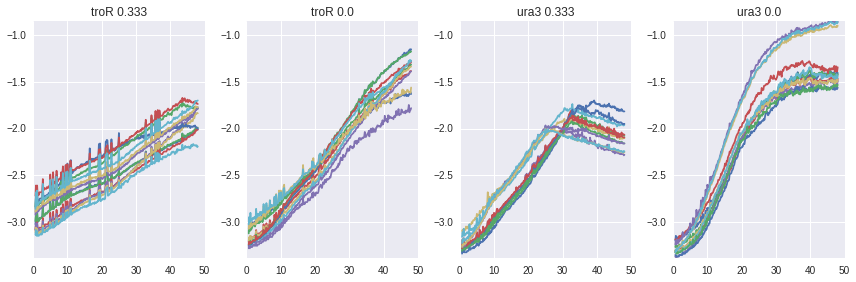

In [4]:
data = growth.GrowthData(pd.read_csv("../data/hsal/hsal.data.csv",index_col=0),pd.read_excel("../data/hsal/hsal.key.xls"))
n = data.data.shape[0]

plt.figure(figsize=(12,4))
data.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4)

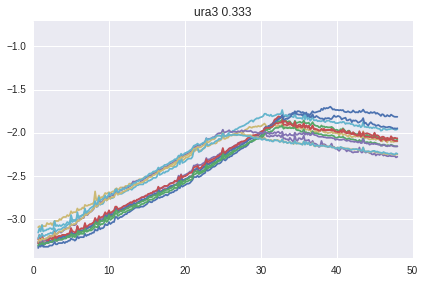

In [5]:
ura3stress = data.select(Strain="ura3",**{'mM PQ':.333})
ura3stress.data.iloc[:,1:] = data.data.loc[:,ura3stress.data.columns.astype('str')[1:]].values

ura3stress.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4)
plt.ylim(-3.45,-.7)
plt.savefig("figures/growthData_ura3_stress.png",bbox_inches="tight",dpi=300)

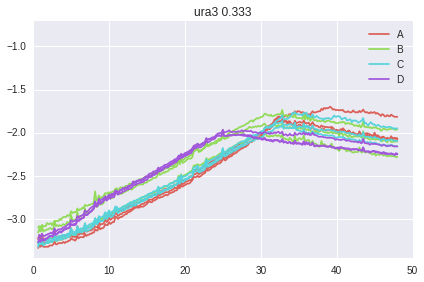

In [6]:
ura3stress = data.select(Strain="ura3",**{'mM PQ':.333})
ura3stress.data.iloc[:,1:] = data.data.loc[:,ura3stress.data.columns.astype('str')[1:]].values

ura3stress.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4,colorby="Bio")
plt.ylim(-3.45,-.7)
plt.savefig("figures/growthData_ura3_stress_bio.png",bbox_inches="tight",dpi=300)

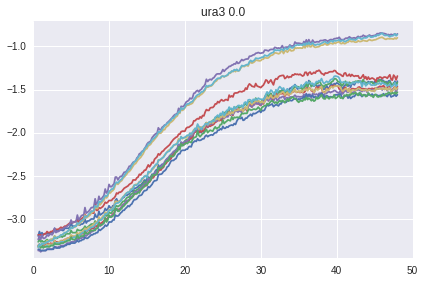

In [7]:
ura3norm = data.select(Strain="ura3",**{'mM PQ':0})
ura3norm.data.iloc[:,1:] = data.data.loc[:,ura3norm.data.columns.astype('str')[1:]].values

ura3norm.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4)
plt.ylim(-3.45,-.7)
plt.savefig("figures/growthData_ura3_norm.png",bbox_inches="tight",dpi=300)

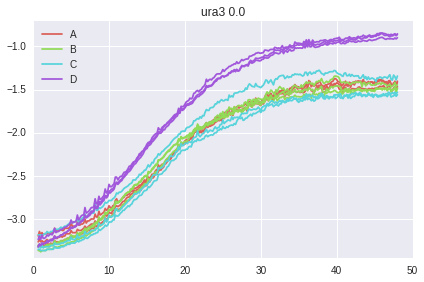

In [8]:
ura3norm = data.select(Strain="ura3",**{'mM PQ':0})
ura3norm.data.iloc[:,1:] = data.data.loc[:,ura3norm.data.columns.astype('str')[1:]].values

ura3norm.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4,colorby="Bio")
plt.ylim(-3.45,-.7)
plt.savefig("figures/growthData_ura3_norm_bio.png",bbox_inches="tight",dpi=300)

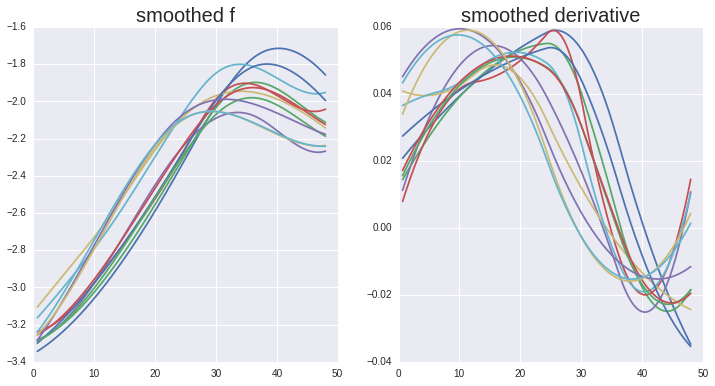

In [9]:
plt.figure(figsize=(12,6))

splines = []
t = ura3stress.data.time.values
for i in range(1,ura3stress.data.shape[1]):
    y = ura3stress.data.iloc[:,i]
    
    s = bspline.Bspline(t,y,s=.2,task=0)
#     k,c,d = scipy.interpolate.splrep(t,y,task=0,s=.2)
#     s.knots,s.coeff,s.degree = k,c,d
    
    splines.append(s)
    
    plt.subplot(121)
    plt.plot(t,splines[-1](t))
    plt.subplot(122)
    plt.plot(t,splines[-1](t,deriv=1))
    
plt.subplot(121)
plt.title("smoothed f",fontsize=20)

plt.subplot(122)
plt.title("smoothed derivative",fontsize=20)

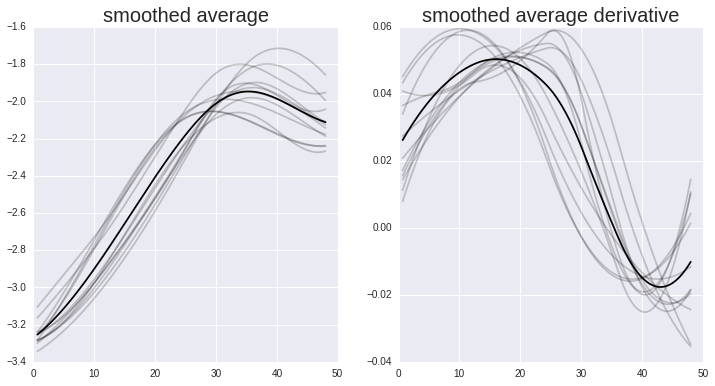

In [10]:
avg = bspline.Bspline(t,np.mean([s(t) for s in splines],0))

plt.figure(figsize=(12,6))

for i in range(0,len(splines)):
    plt.subplot(121)
    plt.plot(t,splines[i](t),'k',alpha=.2)
    plt.subplot(122)
    plt.plot(t,splines[i](t,deriv=1),'k',alpha=.2)
    

plt.subplot(121)
plt.plot(t,avg(t),'k')
plt.subplot(122)
plt.plot(t,avg(t,deriv=1),'k')
    
plt.subplot(121)
plt.title("smoothed average",fontsize=20)

plt.subplot(122)
plt.title("smoothed average derivative",fontsize=20)

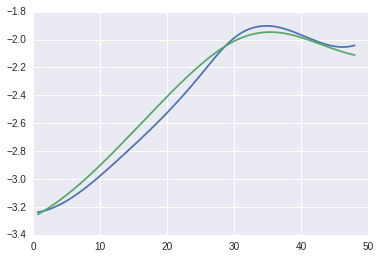

In [10]:
plt.plot(t,splines[2](t))
plt.plot(t,avg(t))

In [11]:
delta = np.mean(t[1:] - t[:-1])
lr = localRegression.RegisterLocalRegression(splines[2](t),avg(t),t,bandwidth=delta*30,ridge=n/32,decay=True)
lr.run(10)

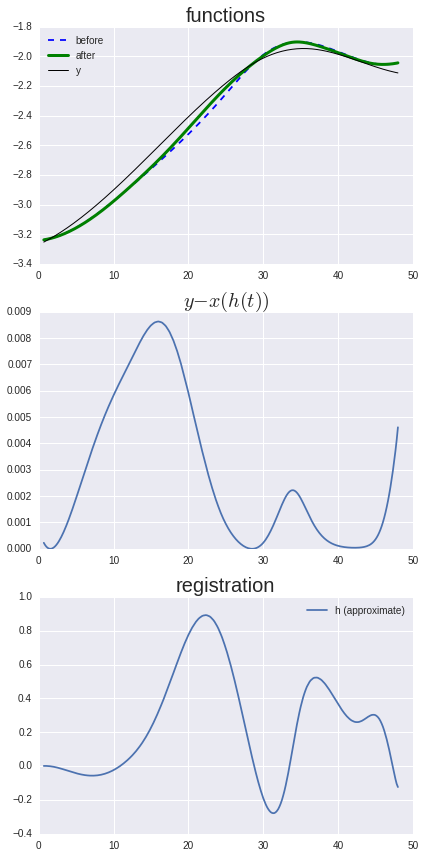

In [12]:
plt.figure(figsize=(6,12))

plt.subplot(311)
plt.title("functions",fontsize=20)
plt.plot(t,lr.xhats[0](t),'b--',label='before');
plt.plot(t,lr.xhats[-1](t),'g',label='after',linewidth=3);
plt.plot(t,avg(t),'k',linewidth=1,label='y');
plt.legend(loc="best")

plt.subplot(312)
plt.title("$y - x(h(t))$",fontsize=20)
plt.plot(t,(lr.xspline(t)-avg(t))**2);

plt.subplot(313)
plt.title("registration",fontsize=20)
plt.plot(t,lr.h()(t)-t,label="h (approximate)")
# plt.plot(t,h-t,'k',label="h (actual)")
plt.legend(loc="best")

plt.tight_layout()

In [11]:
class Register(object):
    
    def __init__(self,x,t,N=None,localRegressionIter=None,localRegressionKwargs=None):
        self.xinit = self.xcurrent = x
        self.xhistory = [x]
        self.avghistory = []
        self.registerHistory = []
        self.k = len(x)
        self.t = t
        self.N = N
        if N is None:
            self.N = 1
        
        self.localRegressionIter = localRegressionIter
        if localRegressionIter is None:
            self.localRegressionIter = 1
            
        self.localRegressionKwargs = localRegressionKwargs
        if localRegressionKwargs is None:
            self.localRegressionKwargs = {}
        
        
    def _iterate(self,):
        avg = bspline.Bspline(self.t,np.mean([s(self.t) for s in self.xcurrent],0))
        self.avghistory.append(avg)
        xnext = []
        self.registerHistory.append([])
        
        for i in range(self.k):
            lr = localRegression.RegisterLocalRegression(self.xcurrent[i](self.t),
                                                         avg(self.t),self.t,
                                                         **self.localRegressionKwargs)
            lr.run(self.localRegressionIter)
            xnext.append(lr.xspline)
            self.registerHistory[-1].append(lr.h())
            
        xcurrent = xnext
        self.xhistory.append(xnext)
        
    def run(self):
        for i in range(self.N):
            print i
            self._iterate()

In [12]:
splineDeriv = [bspline.Bspline(t,s(t,deriv=1)) for s in splines]

delta = t[-1] - t[0]

tregister = np.linspace(t[0],t[-1],100)

In [13]:
reg = Register(splineDeriv,tregister,5,3,{"bandwidth":delta/2,"decay":False,"ridge":n/1024})

In [14]:
reg.run()

0
1
2
3
4


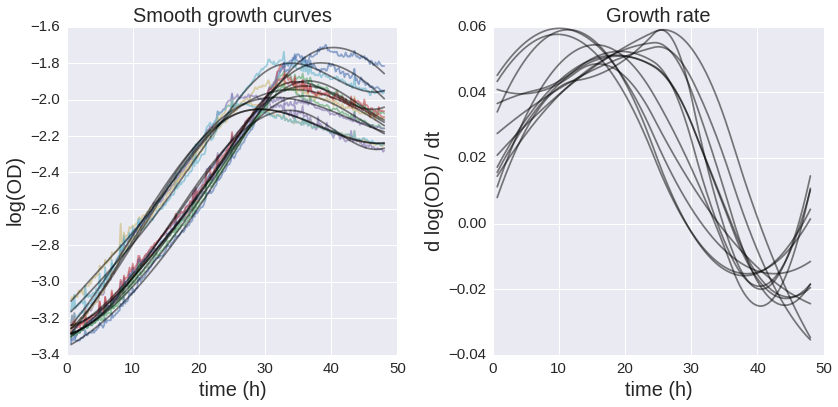

In [39]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title("Smooth growth curves",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)
plt.plot(t,ura3stress.data.iloc[:,1:],alpha=.6,label="raw data")

plt.subplot(122)
plt.title("Growth rate",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("d log(OD) / dt",fontsize=20)

for i in range(0,len(splines)):
    plt.subplot(122)
#     plt.plot(t,reg.xhistory[0][i](t),'k',alpha=.5)
    plt.plot(t,splines[i](t,deriv=1),'k',alpha=.5)
    plt.subplot(121)
#     plt.plot(t,reg.xhistory[0][i](t,deriv=-1),'k',alpha=.5)
    plt.plot(t,splines[i](t,deriv=0),'k',alpha=.5)
    
plt.tight_layout(pad=2)
plt.savefig("figures/growthData_register_before.png",dpi=300,bbox_inches="tight")

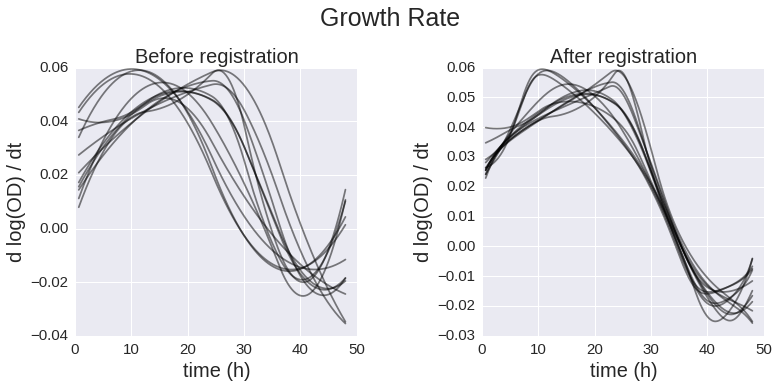

In [45]:
plt.figure(figsize=(12,6))

plt.suptitle("Growth Rate",fontsize=25)

plt.subplot(121)
plt.title("Before registration",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("d log(OD) / dt",fontsize=20)

plt.subplot(122)
plt.title("After registration",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("d log(OD) / dt",fontsize=20)

for i in range(0,len(splines)):
    plt.subplot(121)
    plt.plot(t,splines[i](t,deriv=1),'k',alpha=.5)
    plt.subplot(122)
    plt.plot(t,reg.xhistory[-1][i](t,deriv=0),'k',alpha=.5)
    
plt.tight_layout(pad=5)
plt.savefig("figures/growthData_register_beforeAfter.png",dpi=300,bbox_inches="tight")

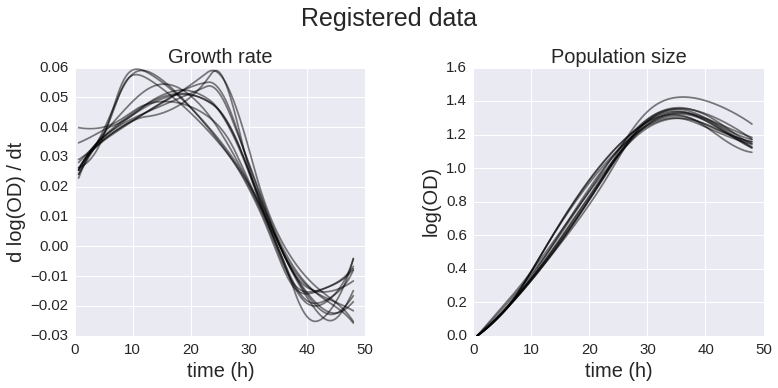

In [49]:
plt.figure(figsize=(12,6))

plt.suptitle("Registered data",fontsize=25)

plt.subplot(121)
plt.title("Growth rate",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("d log(OD) / dt",fontsize=20)

plt.subplot(122)
plt.title("Population size",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)

for i in range(0,len(splines)):
    plt.subplot(122)
    plt.plot(t,reg.xhistory[-1][i](t,deriv=-1),'k',alpha=.5)
    plt.subplot(121)
    plt.plot(t,reg.xhistory[-1][i](t,deriv=0),'k',alpha=.5)
    
plt.tight_layout(pad=5)
plt.savefig("figures/growthData_register_after.png",dpi=300,bbox_inches="tight")

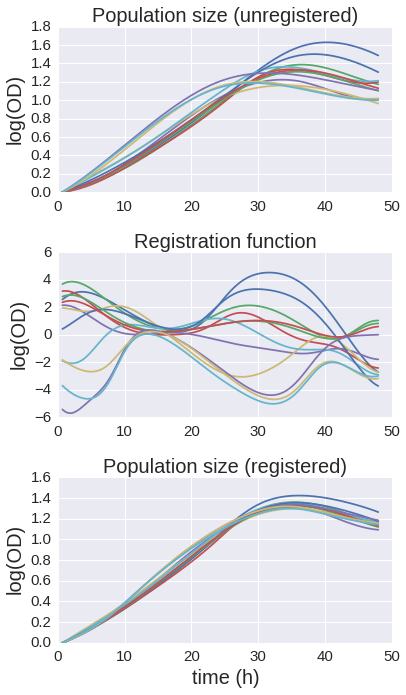

In [19]:
plt.figure(figsize=(6,10))
plt.subplot(311)
[plt.plot(t,h(t,deriv=-1)) for h in reg.xhistory[0]]
plt.title("Population size (unregistered)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)

plt.subplot(312)
[plt.plot(t,h(t)-t) for h in reg.registerHistory[-1]]
plt.title("Registration function",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)


plt.subplot(313)
[plt.plot(t,h(t,deriv=-1)) for h in reg.xhistory[-1]]
plt.title("Population size (registered)",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)

plt.tight_layout(pad=2)

plt.savefig("figures/ura3_register_beforeAfter_growth.png",bbox_inches="tight",dpi=300)

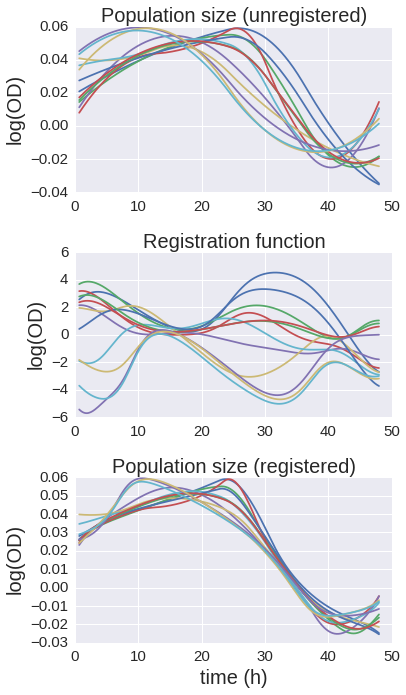

In [21]:
plt.figure(figsize=(6,10))
plt.subplot(311)
[plt.plot(t,h(t,deriv=0)) for h in reg.xhistory[0]]
plt.title("Population size (unregistered)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)

plt.subplot(312)
[plt.plot(t,h(t)-t) for h in reg.registerHistory[-1]]
plt.title("Registration function",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)


plt.subplot(313)
[plt.plot(t,h(t,deriv=0)) for h in reg.xhistory[-1]]
plt.title("Population size (registered)",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)

plt.tight_layout(pad=2)

plt.savefig("figures/ura3_register_beforeAfter_deriv.png",bbox_inches="tight",dpi=300)

In [108]:
tNew = np.ravel(t.tolist()*len(splines))
yNew = np.ravel([s(t,deriv=-1) for s in reg.xhistory[0]])

tNew = tNew[::3]
yNew = yNew[::3]

tNew.shape

(1140,)

In [109]:
gpBefore = GPy.models.GPRegression(tNew[:,None],yNew[:,None])
gpBefore.optimize()
print gpBefore


Name                              : GP regression
Log-likelihood                    : 902.415119923
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  rbf.variance             |  0.505145485168  |     +ve      |         |         
  rbf.lengthscale          |   22.6955656942  |     +ve      |         |         
  Gaussian_noise.variance  |  0.011658995213  |     +ve      |         |         


In [84]:
tNew = np.ravel(t.tolist()*len(splines))
yNew = np.ravel([s(t,deriv=-1) for s in reg.xhistory[-1]])

tNew = tNew[::3]
yNew = yNew[::3]

tNew.shape

(1140,)

In [85]:
gpAfter = GPy.models.GPRegression(tNew[:,None],yNew[:,None])
gpAfter.optimize()
print gpAfter


Name                              : GP regression
Log-likelihood                    : 2209.11155493
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |       Value        |  Constraint  |  Prior  |  Tied to
  rbf.variance             |     0.48922724935  |     +ve      |         |         
  rbf.lengthscale          |     16.3746049514  |     +ve      |         |         
  Gaussian_noise.variance  |  0.00115478896944  |     +ve      |         |         


In [136]:
gpAfter.log_likelihood() - gpBefore.log_likelihood()

1306.6964350105573

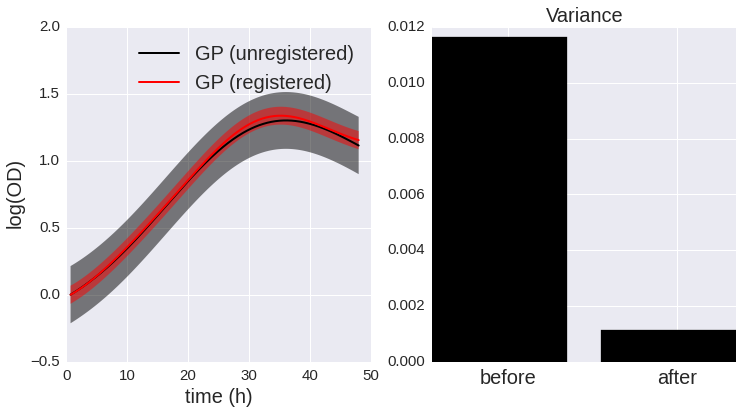

In [134]:
fig,ax = plt.subplots(figsize=(12,6))

plt.subplot(121)
mu,var = gpBefore.predict(t[:,None])
var = np.sqrt(var)
plt.plot(t,mu,'k',linewidth=2,label="GP (unregistered)")
plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([mu - 1.9600 * var,
                       (mu + 1.9600 * var)[::-1]]),alpha=.5, fc='k', ec='None')

mu,var = gpAfter.predict(t[:,None])
var = np.sqrt(var)
plt.plot(t,mu,'r',linewidth=2,label="GP (registered)")
plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([mu - 1.9600 * var,
                       (mu + 1.9600 * var)[::-1]]),alpha=.5, fc='r', ec='None')

plt.legend(loc="best",fontsize=20)
plt.ylabel("log(OD)",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(122)
plt.title("Variance",fontsize=20)
plt.bar([0],[gpBefore.likelihood.gaussian_variance()],color="k")
plt.bar([1],[gpAfter.likelihood.gaussian_variance()],color="k")
plt.xticks([0.45,1.45],['before','after'],fontsize=20)
plt.yticks(fontsize=15)

plt.savefig("figures/growthData_register_gp.png",dpi=300,bbox_inches="tight")

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8]),
 <a list of 10 Text yticklabel objects>)

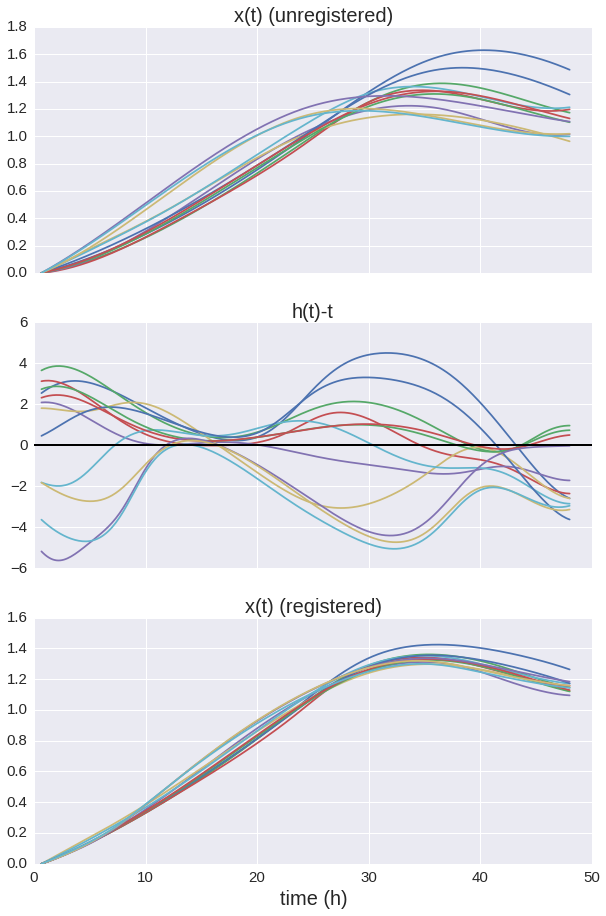

In [76]:
plt.figure(figsize=(10,15))

for i in range(0,len(splines)):
    plt.subplot(311)
    plt.plot(t,reg.xhistory[0][i](t,deriv=-1),alpha=1)
    plt.subplot(312)
    plt.plot(t,reg.registerHistory[-1][i](t)-t,alpha=1)
    plt.subplot(313)
    plt.plot(t,reg.xhistory[-1][i](t,deriv=-1),alpha=1)
    
    
plt.subplot(311)
plt.title("x(t) (unregistered)",fontsize=20)
xt = plt.xticks()
plt.xticks(xt[0],['']*len(plt.xticks()))
plt.yticks(fontsize=15)

plt.subplot(312)
plt.title("h(t)-t",fontsize=20)
plt.plot([0,50],[0,0],'k',linewidth=2)
xt = plt.xticks()
plt.xticks(xt[0],['']*len(plt.xticks()))
plt.yticks(fontsize=15)

plt.subplot(313)
plt.title("x(t) (registered)",fontsize=20)
plt.xlabel("time (h)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

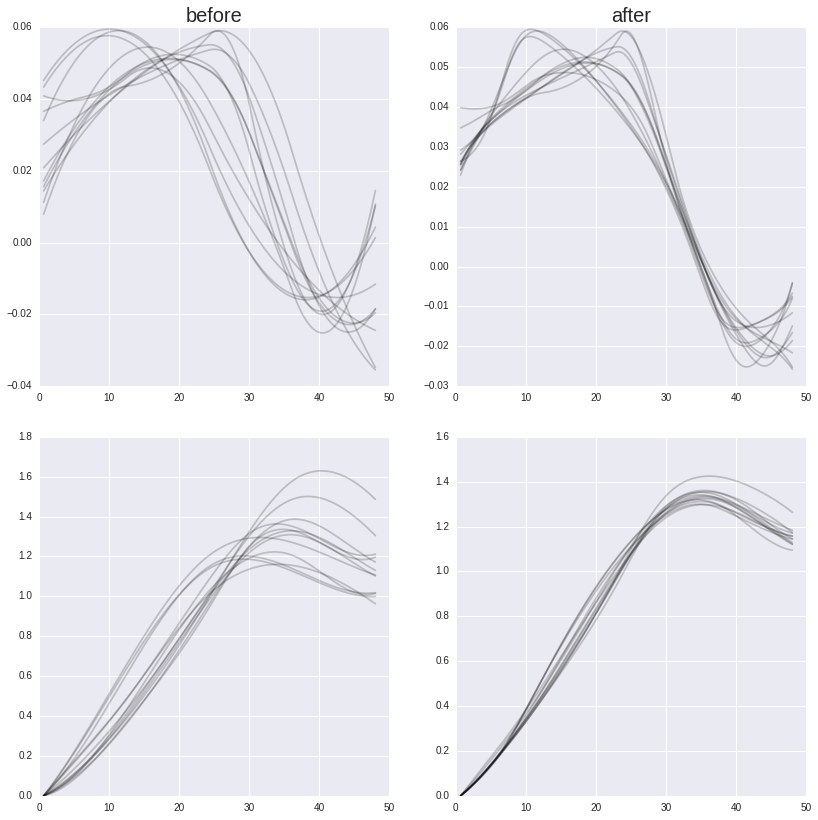

In [18]:
plt.figure(figsize=(12,12))

for i in range(0,len(splines)):
    plt.subplot(221)
    plt.plot(t,reg.xhistory[0][i](t),'k',alpha=.2)
    plt.subplot(223)
    plt.plot(t,reg.xhistory[0][i](t,deriv=-1),'k',alpha=.2)
    
    plt.subplot(222)
    plt.plot(t,reg.xhistory[-1][i](t,deriv=0),'k',alpha=.2)
    plt.subplot(224)
    plt.plot(t,reg.xhistory[-1][i](t,deriv=-1),'k',alpha=.2)
    

# plt.subplot(221)
# plt.plot(t,avg(t,deriv=-1),'k')
# plt.subplot(222)
# plt.plot(t,avg(t,deriv=1),'k')
# plt.subplot(223)
# # plt.plot(t,avg2(t,deriv=-1),'k')
# plt.subplot(224)
# plt.plot(t,avg2(t,deriv=0),'k')
# plt.suptitle("smoothed average",fontsize=20)

plt.subplot(221)

plt.title("before",fontsize=20)

# plt.subplot(222)
# plt.title("smoothed average derivative",fontsize=20)

plt.subplot(222)
plt.title("after",fontsize=20)

plt.tight_layout(pad=3.0)

plt.savefig("figures/growthData_register.png",dpi=300,bbox_inches="tight")

In [167]:
plt.figure(figsize=(10,10))
[plt.plot(t,hf(t)-t) for hf in reg.registerHistory[-1]]

NameError: name 'reg' is not defined

[[<matplotlib.lines.Line2D at 0x7f61334f8c10>],

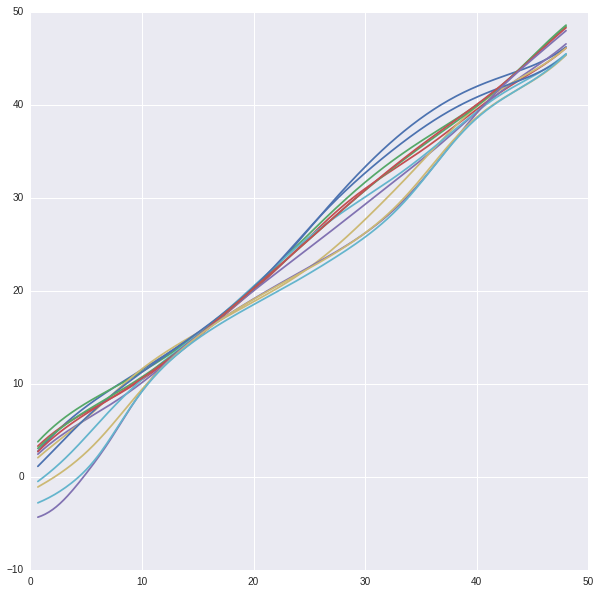

In [258]:
plt.figure(figsize=(10,10))
[plt.plot(t,hf(t)) for hf in reg.registerHistory[-1]]

[[<matplotlib.lines.Line2D at 0x7f61350ea810>],

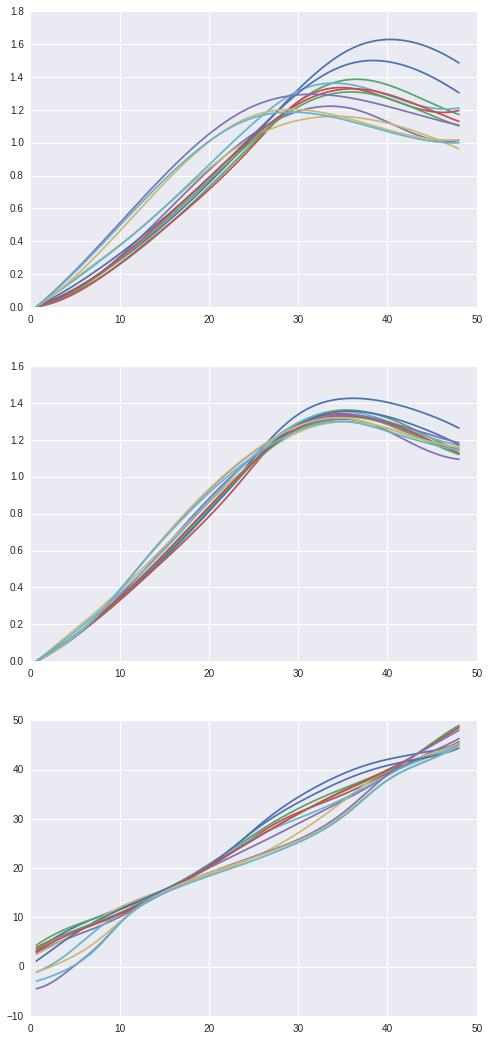

In [232]:
plt.figure(figsize=(8,18))

for i in range(0,len(splines)):
    plt.subplot(311)
    plt.plot(t,reg.xhistory[0][i](t,deriv=-1))
    
    plt.subplot(312)
    plt.plot(t,reg.xhistory[-1][i](t,deriv=-1))
    
plt.subplot(313)
[plt.plot(t,hf(t)) for hf in reg.registerHistory[-1]]

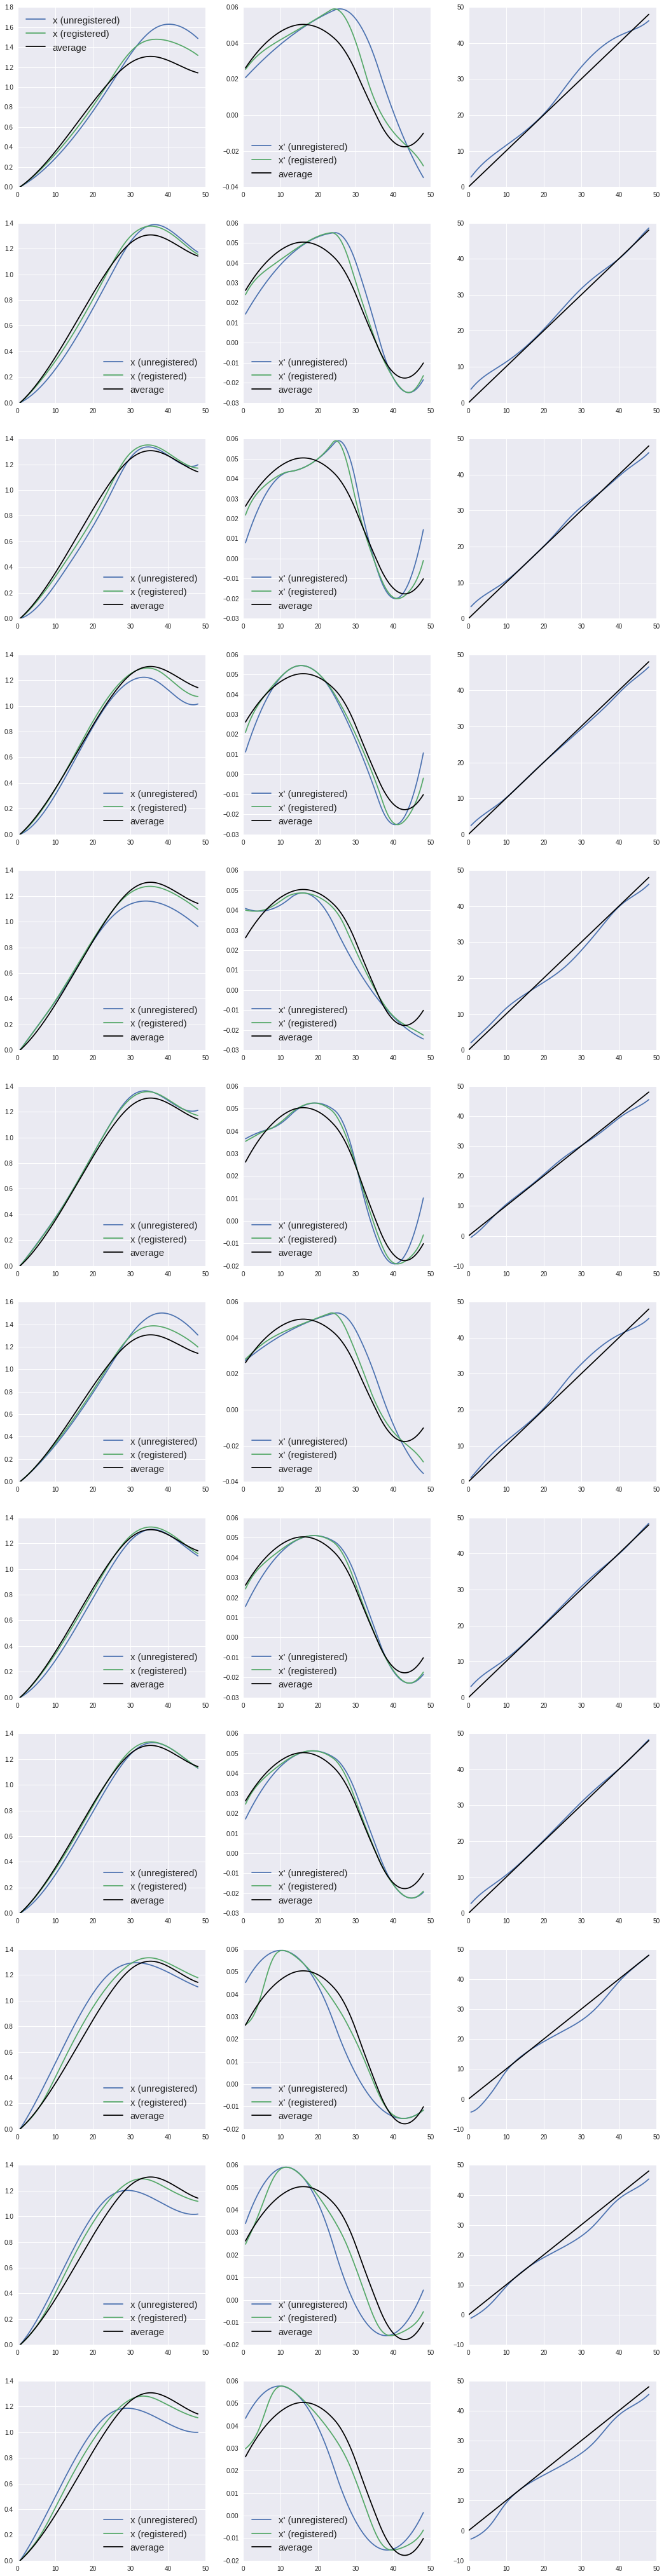

In [259]:
plt.figure(figsize=(3*6,6*len(splines)))

for i in range(0,len(splines)):
    plt.subplot(len(splines),3,3*i+1)
    plt.plot(t,reg.xhistory[0][i](t,deriv=-1),label="x (unregistered)")
    plt.plot(t,reg.xhistory[-1][i](t,deriv=-1),label="x (registered)")
    plt.plot(t,reg.avghistory[-1](t,deriv=-1),'k',label="average")
    plt.legend(loc="best",fontsize=15)
    
    plt.subplot(len(splines),3,3*i+2)
    plt.plot(t,reg.xhistory[0][i](t,deriv=0),label="x' (unregistered)")
    plt.plot(t,reg.xhistory[-1][i](t,deriv=0),label="x' (registered)")
    plt.plot(t,reg.avghistory[-1](t,deriv=0),'k',label="average")
    plt.legend(loc="best",fontsize=15)
    
    plt.subplot(len(splines),3,3*i+3)
    plt.plot(t,reg.registerHistory[-1][i](t))
    plt.plot([0,t[-1]],[0,t[-1]],'k')

# Generalize analysis 

In [22]:
def analyze(data,smooth=.2):
    splines = []
    t = data.data.time.values
    for i in range(1,data.data.shape[1]):
        y = data.data.iloc[:,i]
        s = bspline.Bspline(t,y,s=smooth,task=0)
        splines.append(s)
        
    splineDeriv = [bspline.Bspline(t,s(t,deriv=1)) for s in splines]
    delta = t[-1] - t[0]
    tregister = np.linspace(t[0],t[-1],100)
    
    reg = Register(splineDeriv,tregister,5,3,{"bandwidth":delta/2,"decay":False,"ridge":n/1024})
    reg.run()
        
    return splines,reg

In [249]:
splines,reg = analyze(ura3norm)

0


KeyboardInterrupt: 

[[<matplotlib.lines.Line2D at 0x7f33a113fa90>],

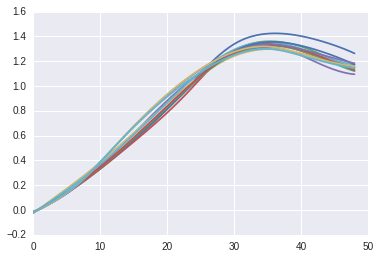

In [160]:
[plt.plot(data.data.time,s(data.data.time,deriv=-1))  for s in reg.xhistory[-1]]

# Test multithread optimization 

In [263]:
import threading

In [293]:
def registerIterationSerial():
    for i in range(reg.k):
        lr = localRegression.RegisterLocalRegression(reg.xinit[i](tregister),
                                                     reg.avghistory[0](tregister),tregister,
                                                     **reg.localRegressionKwargs)
        lr.run(reg.localRegressionIter)

In [294]:
%timeit registerIterationSerial()

1 loops, best of 3: 22.3 s per loop


In [269]:
def registerIterationParallel():

    threads = []

    for i in range(reg.k):
        lr = localRegression.RegisterLocalRegression(reg.xcurrent[i](t),
                                                     reg.avghistory[-1](t),t,
                                                     **reg.localRegressionKwargs)
        thread = threading.Thread(target=lr.run)
        threads.append(thread)
        thread.start()
        
    [thread.join() for thread in threads]

In [270]:
%timeit registerIterationParallel()

1 loops, best of 3: 1min 14s per loop


In [282]:
reload(localRegression)

<module 'pyFDA.register.localRegression' from '../pyFDA/register/localRegression.py'>

In [273]:
def registerIterationLocalRegressionParallel():
    for i in range(reg.k):
        lr = localRegression.RegisterLocalRegression(reg.xinit[i](tregister),
                                                     reg.avghistory[0](tregister),tregister,parallel=True,
                                                     **reg.localRegressionKwargs)
        lr.run(reg.localRegressionIter)

In [283]:
%timeit registerIterationLocalRegressionParallel()

1 loops, best of 3: 4min 17s per loop


In [287]:
gn = lr.gaussNewton(0)

In [288]:
%timeit gn.run()

10 loops, best of 3: 20.6 ms per loop


In [289]:
lr = localRegression.RegisterLocalRegression(reg.xinit[0](t),
                                                     reg.avghistory[0](t),t,
                                                     **reg.localRegressionKwargs)

In [290]:
%timeit lr.run(reg.localRegressionIter)

1 loops, best of 3: 15.7 s per loop


In [291]:
lr = localRegression.RegisterLocalRegression(reg.xinit[0](tregister),
                                                     reg.avghistory[0](tregister),tregister,
                                                     **reg.localRegressionKwargs)

In [292]:
%timeit lr.run(reg.localRegressionIter)

1 loops, best of 3: 2.2 s per loop


# Bayesian Model 

In [116]:
from pyFDA.register import bayesianRegistration
reload(bayesianRegistration)

<module 'pyFDA.register.bayesianRegistration' from '../pyFDA/register/bayesianRegistration.pyc'>

In [117]:
ind = 5
time = ura3stress.data.time.values[::5]
od = ura3stress.data.iloc[::5,1:].values

od.shape

(57, 12)

In [118]:
bayesianRegister = bayesianRegistration.BayesianRegister(time,od,.1)

In [119]:
bayesianRegister.run(1000)

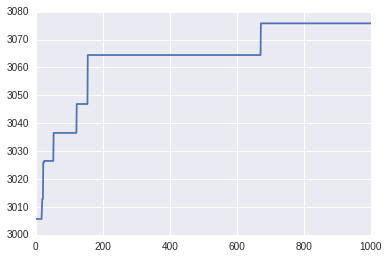

In [128]:
plt.plot(bayesianRegister.probHistory)

In [129]:
len(bayesianRegister.hPosterior())

1001

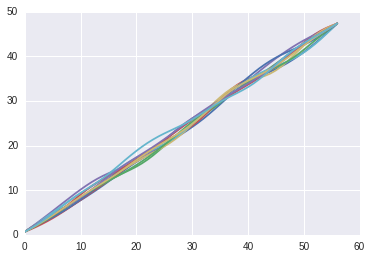

In [126]:
plt.plot(bayesianRegister.hPosterior()[-1]);

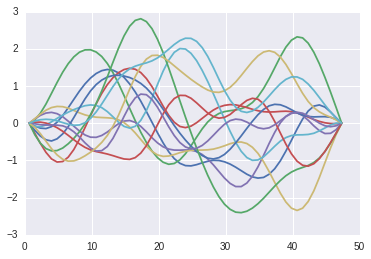

In [136]:
plt.plot(time,bayesianRegister.hPosterior()[0]-np.array([time]*12).T);

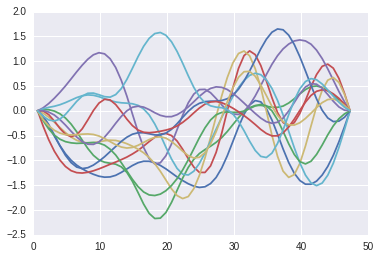

In [138]:
plt.plot(time,bayesianRegister.hHistory[-1]-np.array([time]*12).T);

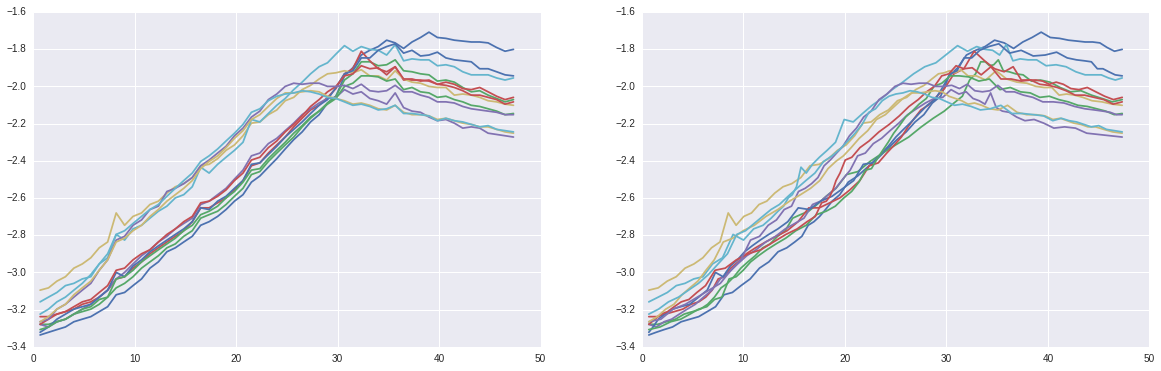

In [165]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(time,od)

plt.subplot(122)
# plt.plot(bayesianRegister.hPosterior()[0],od)
plt.plot(bayesianRegister.hHistory[500],od)

In [149]:
bayesianRegistration.proportionalLogPosterior(time,bayesianRegister.hHistory[0],od,bayesianRegister.regPrior,verbose=True)

total=3005.69, prior-ll=2541.99, ll=463.70


3005.685141482234

In [150]:
bayesianRegistration.proportionalLogPosterior(time,bayesianRegister.hHistory[-1],od,bayesianRegister.regPrior,verbose=True)

total=3075.78, prior-ll=2560.62, ll=515.16


3075.7820594918412

In [154]:
bayesianRegistration.jointLogLikelihood(bayesianRegister.hHistory[0],od)

463.69944944075883

In [153]:
bayesianRegistration.jointLogLikelihood(bayesianRegister.hHistory[-1],od)

515.16104345766496

In [163]:
h = bayesianRegister.hHistory[-1]
y = od
x = []
ynew = []
for i in range(12):
    x.extend(h[:,i].tolist())
    ynew.extend(y[:,i].tolist())

x = np.array(x)[:,None]
ynew = np.array(ynew)[:,None]

gp = GPy.models.GPRegression(x,ynew)
gp.optimize()
print gp


Name                              : GP regression
Log-likelihood                    : 515.161043458
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |       Value       |  Constraint  |  Prior  |  Tied to
  rbf.variance             |    4.70710945436  |     +ve      |         |         
  rbf.lengthscale          |    31.8869357236  |     +ve      |         |         
  Gaussian_noise.variance  |  0.0122900720453  |     +ve      |         |         


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f3ffa40a410>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f3ffa4efb90>],
  [<matplotlib.lines.Line2D at 0x7f3ffa4fe910>]]}

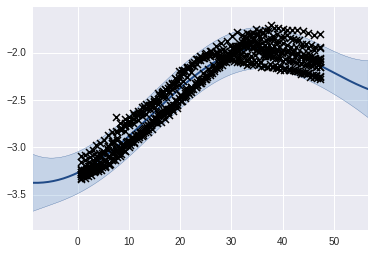

In [158]:
gp.plot()

In [164]:
h = bayesianRegister.hHistory[0]
y = od
x = []
ynew = []
for i in range(12):
    x.extend(h[:,i].tolist())
    ynew.extend(y[:,i].tolist())

x = np.array(x)[:,None]
ynew = np.array(ynew)[:,None]

gp = GPy.models.GPRegression(x,ynew)
gp.optimize()
print gp


Name                              : GP regression
Log-likelihood                    : 463.699449441
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |       Value       |  Constraint  |  Prior  |  Tied to
  rbf.variance             |    3.49102054161  |     +ve      |         |         
  rbf.lengthscale          |    16.6832741471  |     +ve      |         |         
  Gaussian_noise.variance  |  0.0140375133425  |     +ve      |         |         


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f3ffa352510>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f3ffa3b7c90>],
  [<matplotlib.lines.Line2D at 0x7f3ffa344a10>]]}

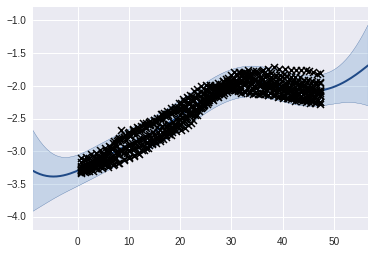

In [160]:
gp.plot()

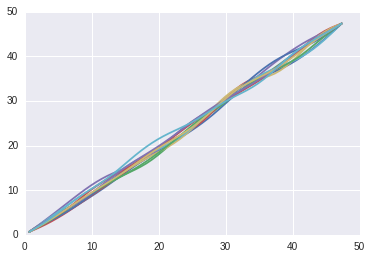

In [144]:
plt.plot(time,bayesianRegister.hHistory[-1])

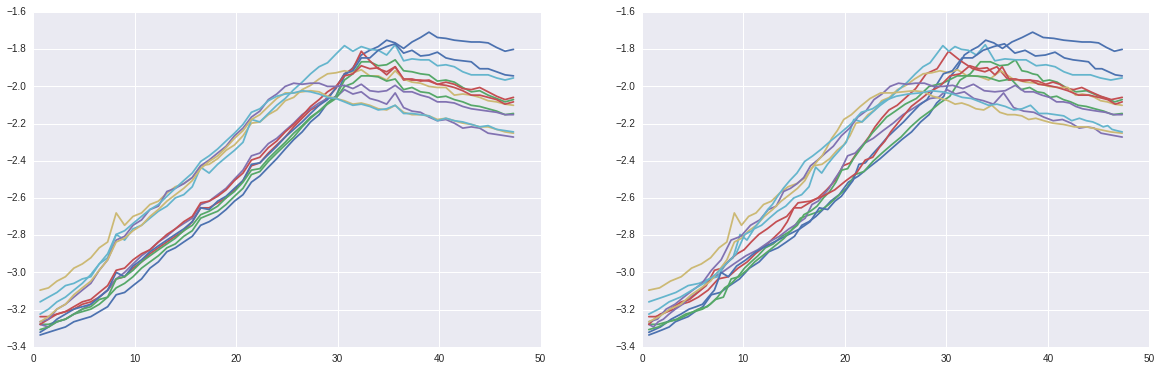

In [111]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(time,od)

plt.subplot(122)
plt.plot(bayesianRegister.hPosterior()[-1],od)

# Ura3 vs SirR 

In [26]:
key = pd.read_excel("../data/hsal/PQ_batch5_key.xlsx")
key['well'] = range(key.shape[0])
data = growth.GrowthData(pd.read_csv("../data/hsal/pq5_data.csv",index_col=0),key)
n = data.data.shape[0]

data.transform(log=True)

# plt.figure(figsize=(25,25))
# data.plot(groupby=['mM PQ'],colorby="Strain",newFig=False,ncols=2)

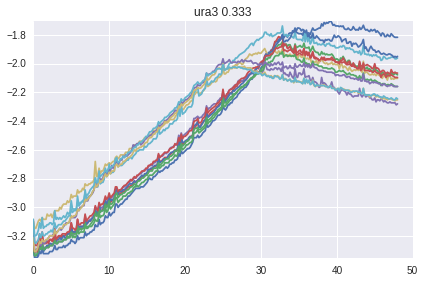

In [27]:
ura3stress = data.select(Strain="ura3",**{'mM PQ':.333})
ura3stress.data.iloc[:,1:] = data.data.loc[:,ura3stress.data.columns.astype('str')[1:]].values

ura3stress.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4)
# plt.savefig("figures/growthData_example.png",bbox_inches="tight",)

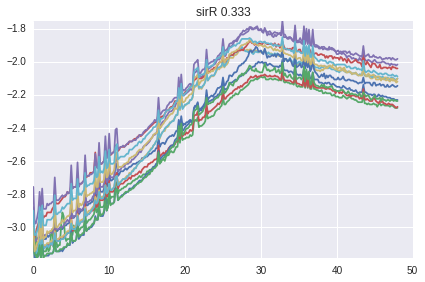

In [28]:
sirRstress = data.select(Strain="sirR",**{'mM PQ':.333})
sirRstress.data.iloc[:,1:] = data.data.loc[:,sirRstress.data.columns.astype('str')[1:]].values

sirRstress.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4)
# plt.savefig("figures/growthData_example.png",bbox_inches="tight",)

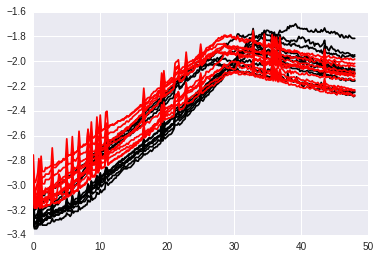

In [29]:
plt.plot(ura3stress.data.time,ura3stress.data.iloc[:,1:],'k')
plt.plot(sirRstress.data.time,sirRstress.data.iloc[:,1:],'r')

In [258]:
sirRanalyze = analyze(sirRstress,smooth=.5)

0
1
2
3
4


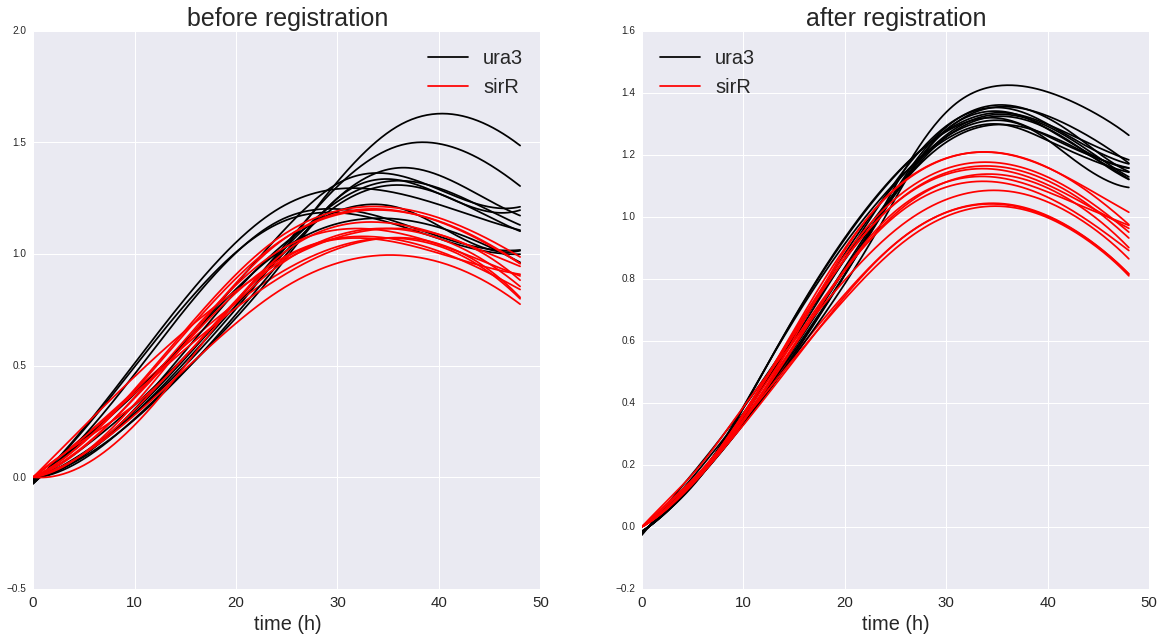

In [259]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("before registration",fontsize=25)
plt.plot(sirRstress.data.time,reg.xhistory[0][0](sirRstress.data.time,deriv=-1),'k',label="ura3")
plt.plot(sirRstress.data.time,sirRanalyze[1].xhistory[0][0](sirRstress.data.time,deriv=-1),'r',label="sirR")
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=-1),'k') for s in reg.xhistory[0][1:]]
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=-1),'r') for s in sirRanalyze[1].xhistory[0][1:]]
plt.xlabel("time (h)",fontsize=20)
plt.xticks(fontsize=15)
plt.legend(loc="best",fontsize=20)

plt.subplot(122)
plt.title("after registration",fontsize=25)
plt.plot(sirRstress.data.time,reg.xhistory[-1][0](sirRstress.data.time,deriv=-1),'k',label="ura3")
plt.plot(sirRstress.data.time,sirRanalyze[1].xhistory[-1][0](sirRstress.data.time,deriv=-1),'r',label="sirR")
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=-1),'k') for s in reg.xhistory[-1][1:]]
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=-1),'r') for s in sirRanalyze[1].xhistory[-1][1:]]
plt.xlabel("time (h)",fontsize=20)
plt.xticks(fontsize=15)
plt.legend(loc="best",fontsize=20)


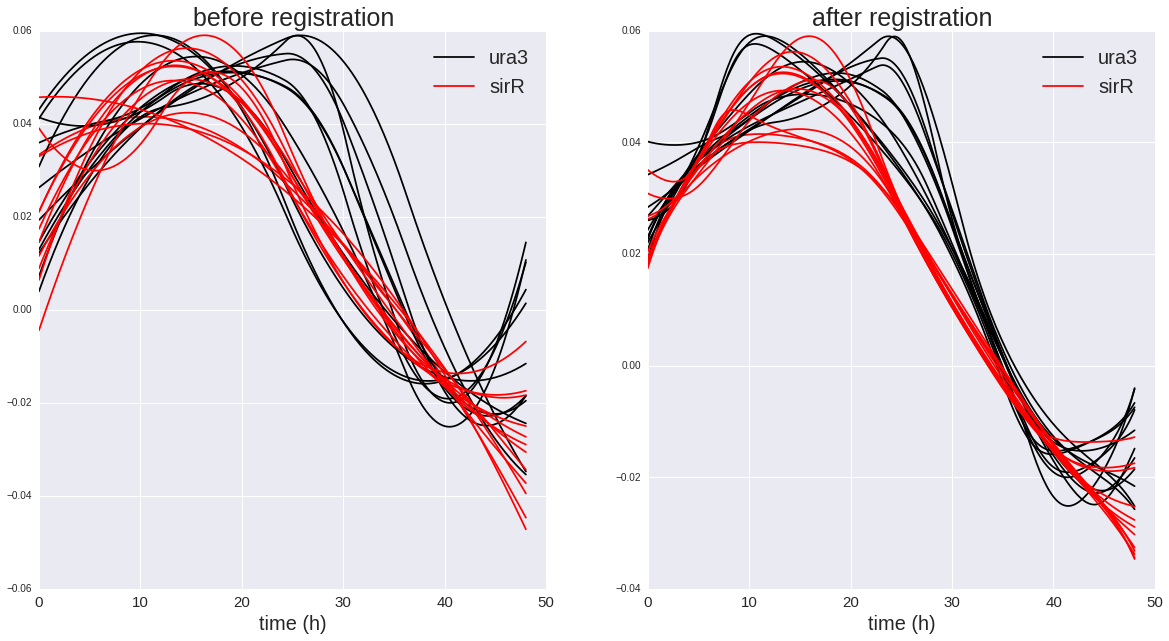

In [263]:
plotComparison(sirRstress.data.time,reg,sirRanalyze[1],'ura3','sirR',0)

In [30]:
def bayesFactor(x,y1,y2):
    gp1 = GPy.models.GPRegression(x,y1)
    gp1.optimize()
    
    gp2 = GPy.models.GPRegression(x,y2)
    gp2.optimize()
    
    mu1,var1 = gp1.predict(x,full_cov=True)
    mu2,var2 = gp2.predict(x,full_cov=True)
    
    return scipy.stats.multivariate_normal.logpdf(y1[:,0],mu1[:,0],var1) - scipy.stats.multivariate_normal.logpdf(y1[:,0],mu2[:,0],var2)
    

In [222]:
t = sirRstress.data.time[::5]

y1 = np.ravel([s(t,deriv=-1) for s in sirRanalyze[1].xhistory[0]])
y2 = np.ravel([s(t,deriv=-1) for s in reg.xhistory[0]])

t = np.ravel([t]*sirRstress.key.shape[0])

print t.shape


(696,)


In [223]:
bayesFactor(t[:,None],y1[:,None],y2[:,None])

513.28897313643972

In [224]:
t = sirRstress.data.time[::5]

y1 = np.ravel([s(t,deriv=-1) for s in sirRanalyze[1].xhistory[-1]])
y2 = np.ravel([s(t,deriv=-1) for s in reg.xhistory[-1]])

t = np.ravel([t]*sirRstress.key.shape[0])

bayesFactor(t[:,None],y1[:,None],y2[:,None])

4110.2126105568159

In [211]:
sirRanalyze[1].xhistory[0]

In [210]:
y1.shape,t.shape

((41616,), (3468,))

(-0.05, 0.2)

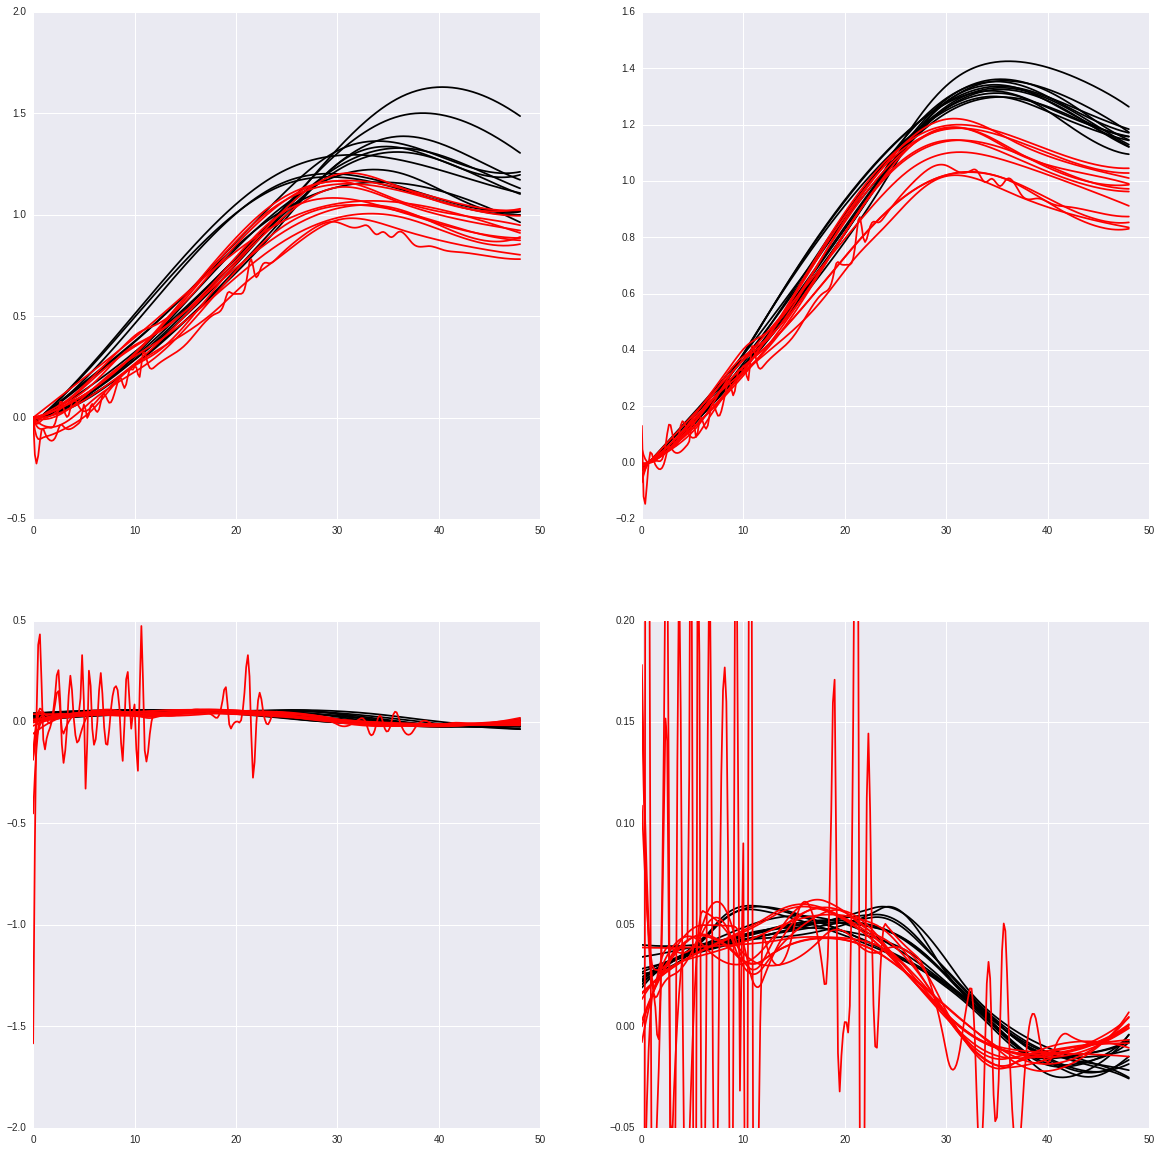

In [184]:
plt.figure(figsize=(20,20))

plt.subplot(221)
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=-1),'k') for s in reg.xhistory[0]]
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=-1),'r') for s in sirRanalyze[1].xhistory[0]]

plt.subplot(222)
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=-1),'k') for s in reg.xhistory[-1]]
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=-1),'r') for s in sirRanalyze[1].xhistory[-1]]

plt.subplot(223)
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=0),'k') for s in reg.xhistory[0]]
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=0),'r') for s in sirRanalyze[1].xhistory[0]]

plt.subplot(224)
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=0),'k') for s in reg.xhistory[-1]]
[plt.plot(sirRstress.data.time,s(sirRstress.data.time,deriv=0),'r') for s in sirRanalyze[1].xhistory[-1]]
plt.ylim(-.05,.2)

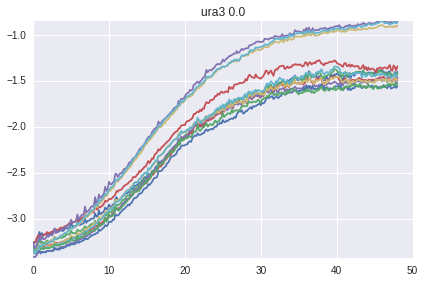

In [31]:
ura3norm = data.select(Strain="ura3",**{'mM PQ':0})
ura3norm.data.iloc[:,1:] = data.data.loc[:,ura3norm.data.columns.astype('str')[1:]].values

ura3norm.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4)

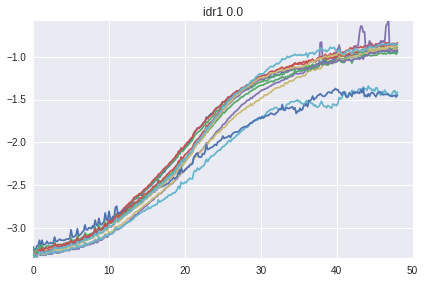

In [32]:
idr1 = data.select(Strain="idr1",**{'mM PQ':0})
idr1.data.iloc[:,1:] = data.data.loc[:,idr1.data.columns.astype('str')[1:]].values

idr1.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4)

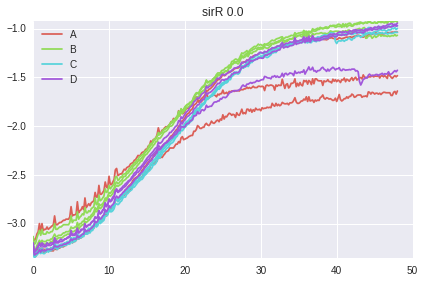

In [33]:
sirRnorm = data.select(Strain="sirR",**{'mM PQ':0})
sirRnorm.data.iloc[:,1:] = data.data.loc[:,sirRnorm.data.columns.astype('str')[1:]].values

sirRnorm.plot(groupby=["Strain",'mM PQ'],newFig=False,ncols=4,colorby="Bio")
plt.savefig("figures/growthData_sirR_norm_bio.png",bbox_inches="tight",dpi=300)

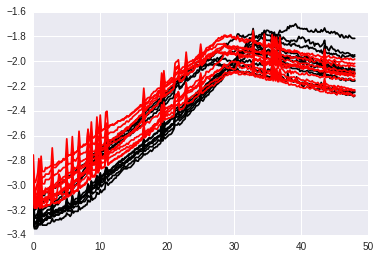

In [34]:
plt.plot(ura3norm.data.time,ura3stress.data.iloc[:,1:],'k')
plt.plot(idr1.data.time,sirRstress.data.iloc[:,1:],'r')

In [35]:
ura3NormAnalyze = analyze(ura3norm)

0
1
2
3
4


In [36]:
idr1analyze = analyze(idr1,1)

0
1
2
3
4


In [37]:
sirRNormAnalyze = analyze(sirRnorm)

0
1
2
3
4


In [308]:
def plotComparison(t,a1,a2,l1,l2,deriv=-1):

    plt.figure(figsize=(20,10))

    plt.subplot(121)
    plt.title("before registration",fontsize=25)
    plt.plot(t,a1.xhistory[0][0](t,deriv=deriv),'k',label=l1)
    plt.plot(t,a2.xhistory[0][0](t,deriv=deriv),'r',label=l2)
    [plt.plot(t,s(t,deriv=deriv),'k') for s in a1.xhistory[0][1:]]
    [plt.plot(t,s(t,deriv=deriv),'r') for s in a2.xhistory[0][1:]]
    plt.xlabel("time (h)",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc="best",fontsize=20)

    plt.subplot(122)
    plt.title("after registration",fontsize=25)
    plt.plot(t,a1.xhistory[-1][0](t,deriv=deriv),'k',label=l1)
    plt.plot(t,a2.xhistory[-1][0](t,deriv=deriv),'r',label=l2)
    [plt.plot(t,s(t,deriv=deriv),'k') for s in a1.xhistory[-1][1:]]
    [plt.plot(t,s(t,deriv=deriv),'r') for s in a2.xhistory[-1][1:]]
    plt.xlabel("time (h)",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc="best",fontsize=20)

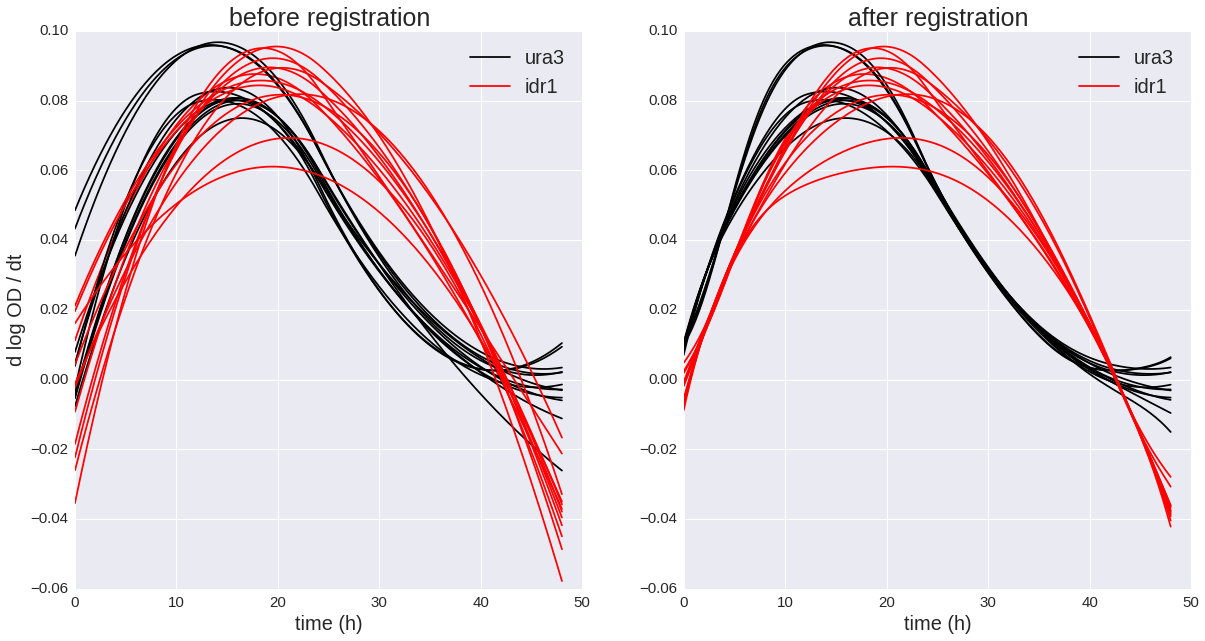

In [313]:
plotComparison(idr1.data.time,ura3NormAnalyze[1],idr1analyze[1],'ura3','idr1',0)

plt.subplot(121)
plt.ylabel("d log OD / dt",fontsize=20)
# plt.subplot(121)
# plt.ylim(-.05,.2)
# plt.subplot(122)
# plt.ylim(-.05,.2)

plt.savefig("figures/idr1_vs_ura3_register_deriv.png",bbox_inches="tight",dpi=300)

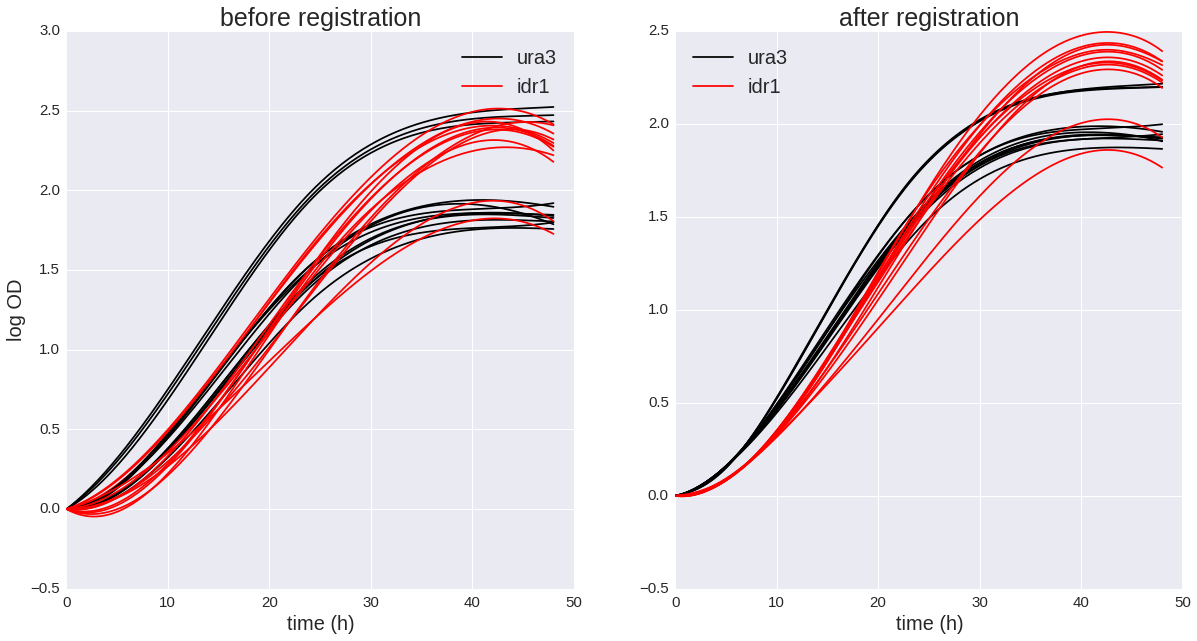

In [314]:
plotComparison(idr1.data.time,ura3NormAnalyze[1],idr1analyze[1],'ura3','idr1',-1)

plt.subplot(121)
plt.ylabel("log OD",fontsize=20)

plt.savefig("figures/idr1_vs_ura3_register_growth.png",bbox_inches="tight",dpi=300)

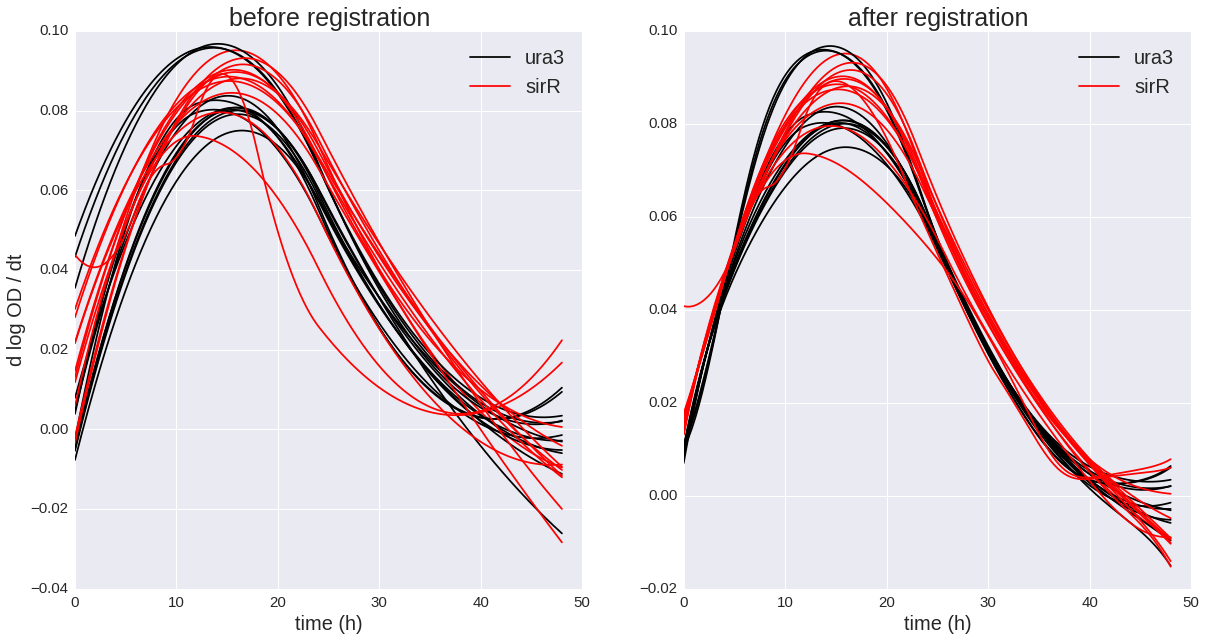

In [322]:
plotComparison(idr1.data.time,ura3NormAnalyze[1],sirRNormAnalyze[1],'ura3','sirR',0)

plt.subplot(121)
plt.ylabel("d log OD / dt",fontsize=20)

plt.savefig("figures/sirR_vs_ura3_register_deriv.png",bbox_inches="tight",dpi=300)

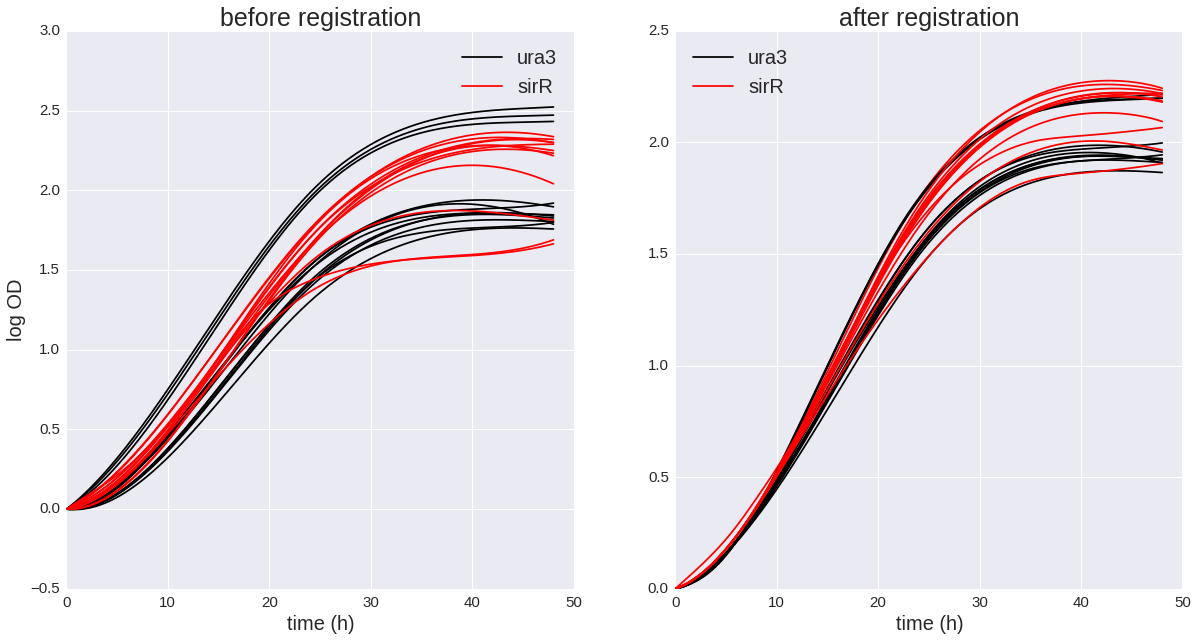

In [323]:
plotComparison(idr1.data.time,ura3NormAnalyze[1],sirRNormAnalyze[1],'ura3','sirR',-1)

plt.subplot(121)
plt.ylabel("log OD",fontsize=20)

plt.savefig("figures/sirR_vs_ura3_register_growth.png",bbox_inches="tight",dpi=300)

In [265]:
rtemp = idr1analyze[1]

In [266]:
rtemp.registerHistory[-1](idr1.data.time)

TypeError: 'list' object is not callable

[[<matplotlib.lines.Line2D at 0x7f339d078190>],

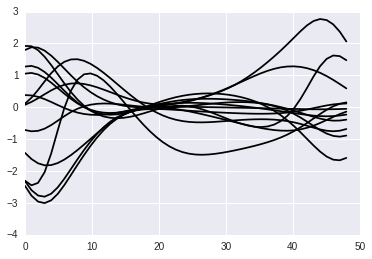

In [271]:
[plt.plot(np.linspace(0,48),s(np.linspace(0,48),deriv=0)-np.linspace(0,48),'k') for s in rtemp.registerHistory[-1]]

In [ ]:
plt.figure(figsize=(6,10))
plt.subplot(311)
[plt.plot(t,h(t,deriv=0)) for h in reg.xhistory[0]]
plt.title("Population size (unregistered)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)

plt.subplot(312)
[plt.plot(t,h(t)-t) for h in reg.registerHistory[-1]]
plt.title("Registration function",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)


plt.subplot(313)
[plt.plot(t,h(t,deriv=0)) for h in reg.xhistory[-1]]
plt.title("Population size (registered)",fontsize=20)
plt.xlabel("time (h)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("log(OD)",fontsize=20)

plt.tight_layout(pad=2)

plt.savefig("figures/ura3_register_beforeAfter_deriv.png",bbox_inches="tight",dpi=300)

In [38]:
def plotRegistration(t,a,deriv=0):

    plt.subplot(311)
    plt.title("before registration",fontsize=25)
    [plt.plot(t,s(t,deriv=deriv)) for s in a.xhistory[0]]
    plt.xlabel("time (h)",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc="best",fontsize=20)
    
    
    plt.subplot(312)
    plt.title("registration functions",fontsize=25)
    [plt.plot(t,s(t)-t) for s in a.registerHistory[-1]]
    plt.xlabel("time (h)",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc="best",fontsize=20)

    plt.subplot(313)
    plt.title("after registration",fontsize=25)
    [plt.plot(t,s(t,deriv=deriv)) for s in a.xhistory[-1]]
    plt.xlabel("time (h)",fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.legend(loc="best",fontsize=20)

 /home/ptonner/dev/pyFDA/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning:No labelled objects found. Use label='...' kwarg on individual plots.


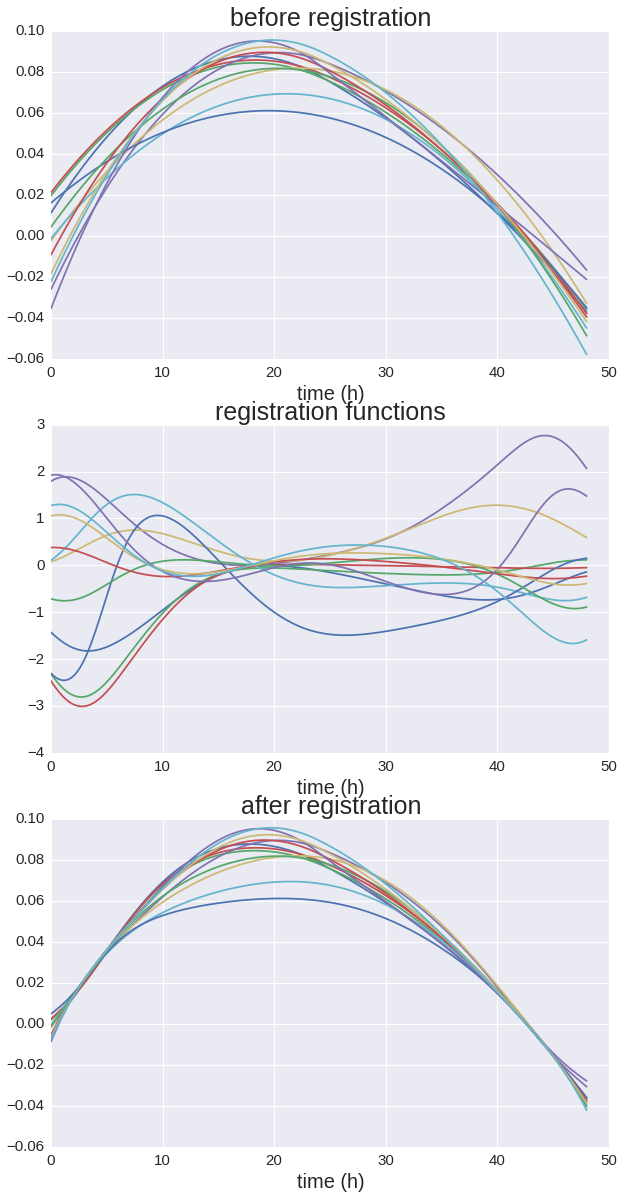

In [39]:
plt.figure(figsize=(10,20))

plotRegistration(idr1.data.time,idr1analyze[1])

plt.savefig("figures/idr1_register_deriv.png",bbox_inches="tight",dpi=300)

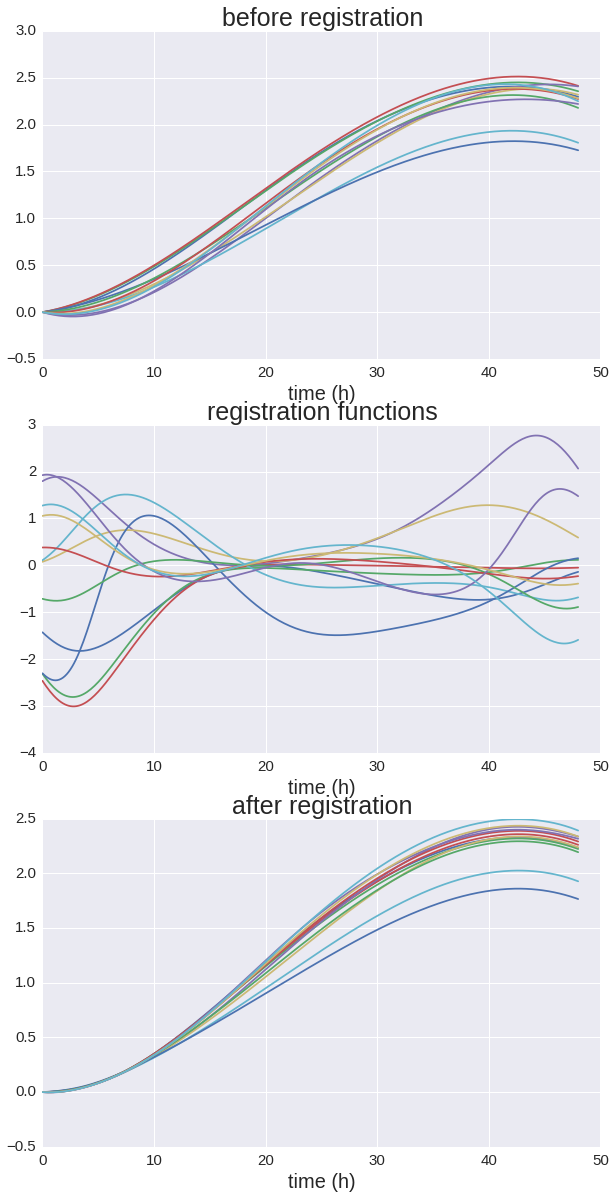

In [40]:
plt.figure(figsize=(10,20))

plotRegistration(idr1.data.time,idr1analyze[1],-1)

plt.savefig("figures/idr1_register_growth.png",bbox_inches="tight",dpi=300)

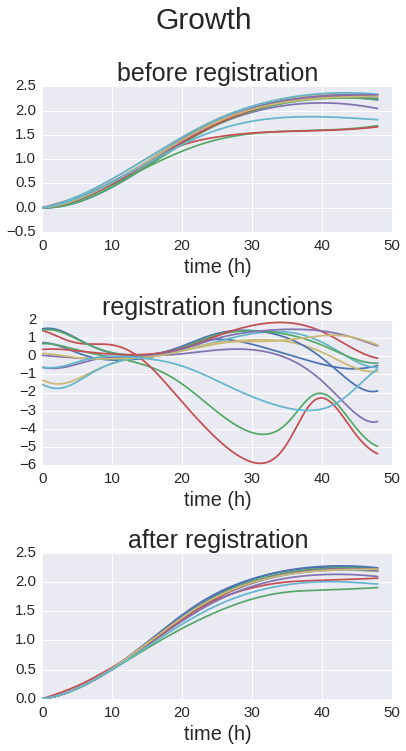

In [53]:
plt.figure(figsize=(6,10))

plotRegistration(sirRnorm.data.time,sirRNormAnalyze[1],-1)

plt.tight_layout(pad=2)
plt.suptitle("Growth",fontsize=30,y=1.05)
plt.savefig("figures/sirR_register_growth.png",bbox_inches="tight",dpi=300)

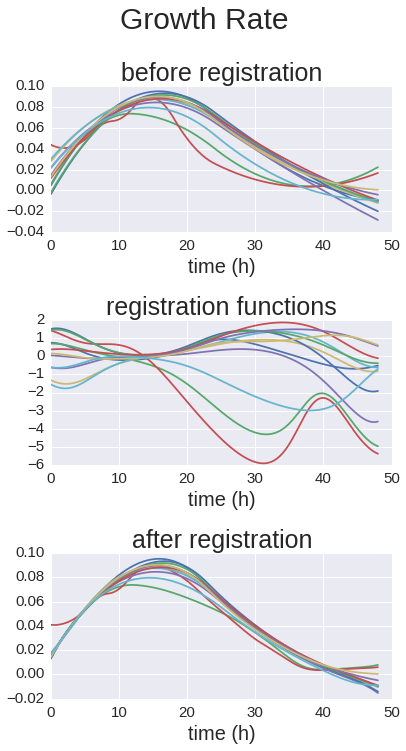

In [54]:
plt.figure(figsize=(6,10))

plotRegistration(sirRnorm.data.time,sirRNormAnalyze[1],0)

plt.tight_layout(pad=2)
plt.suptitle("Growth Rate",fontsize=30,y=1.05)
plt.savefig("figures/sirR_register_deriv.png",bbox_inches="tight",dpi=300)

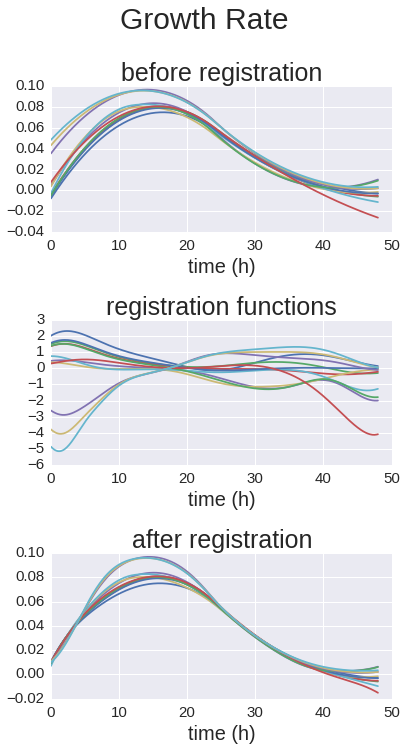

In [52]:
plt.figure(figsize=(6,10))

plotRegistration(ura3norm.data.time,ura3NormAnalyze[1],0)

plt.suptitle("Growth Rate",fontsize=30,y=1.05)
plt.tight_layout(pad=2)
plt.savefig("figures/ura3_register_deriv.png",bbox_inches="tight",dpi=300)

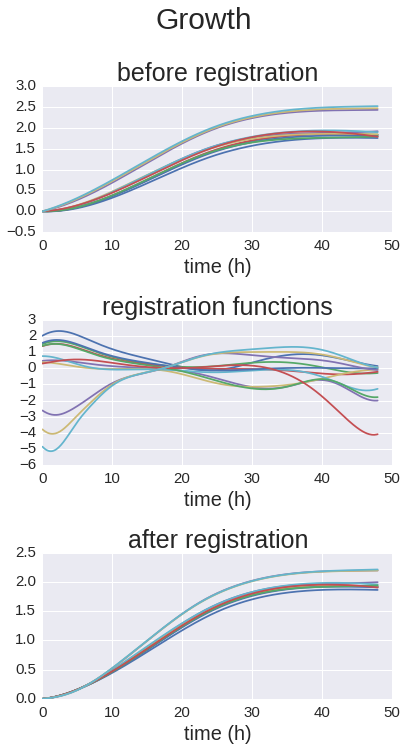

In [51]:
plt.figure(figsize=(6,10))

plotRegistration(ura3norm.data.time,ura3NormAnalyze[1],-1)

plt.suptitle("Growth",fontsize=30,y=1.05)
plt.tight_layout(pad=2)
plt.savefig("figures/ura3_register_growth.png",bbox_inches="tight",dpi=300)

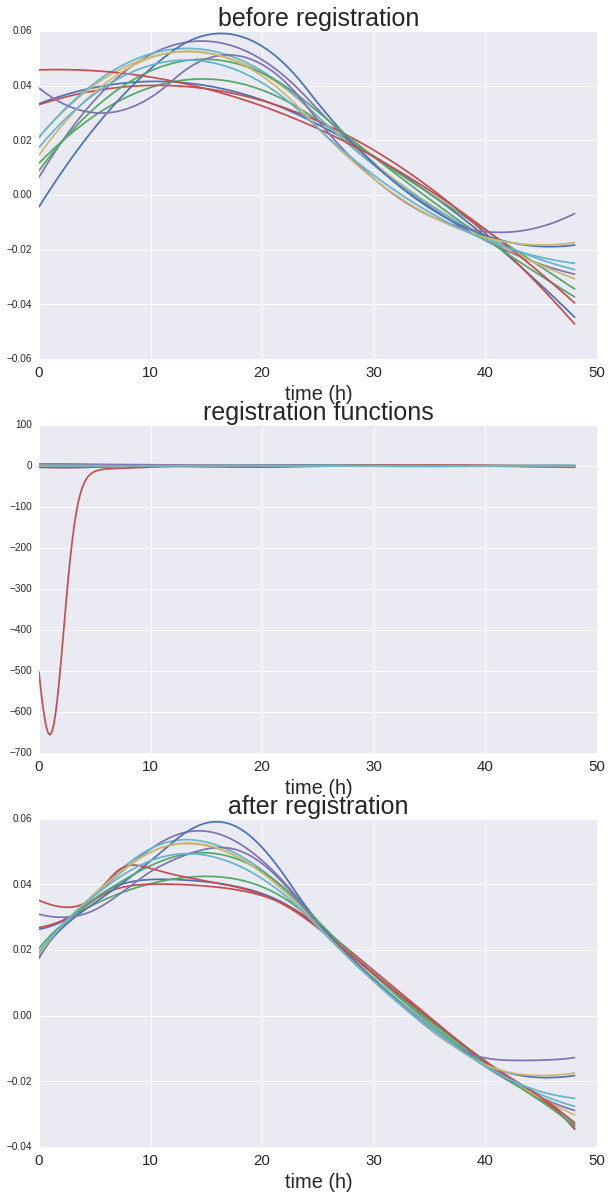

In [298]:
plt.figure(figsize=(10,20))

plotRegistration(sirRstress.data.time,sirRanalyze[1],0)

plt.savefig("figures/sirR_register_deriv.png",bbox_inches="tight",dpi=300)

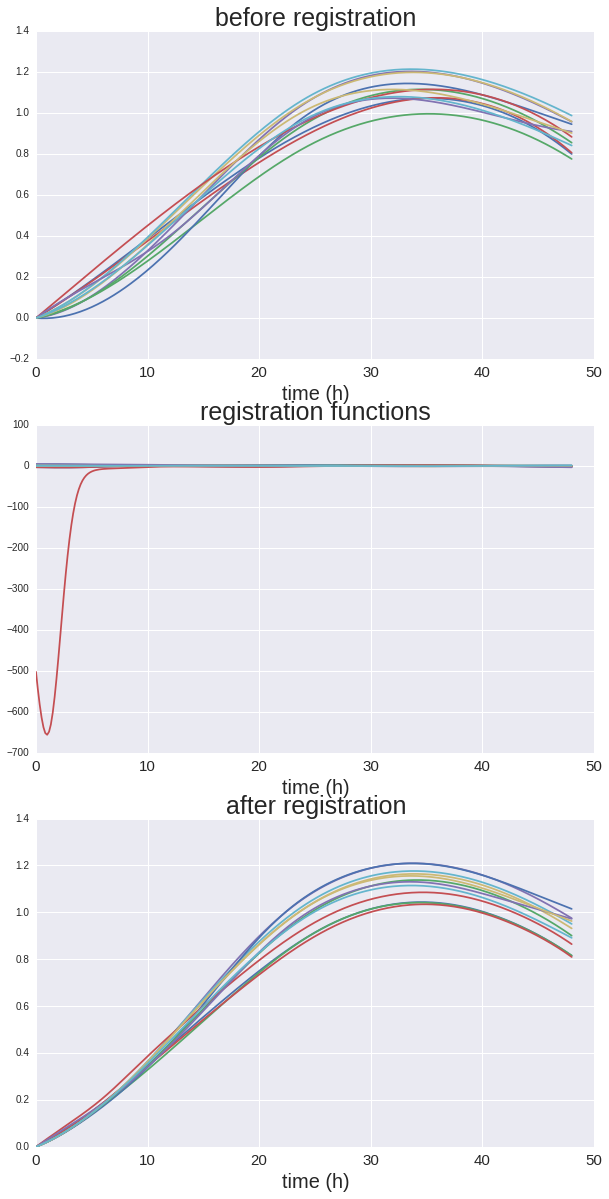

In [297]:
plt.figure(figsize=(10,20))

plotRegistration(sirRstress.data.time,sirRanalyze[1],-1)

plt.savefig("figures/sirR_register_growth.png",bbox_inches="tight",dpi=300)

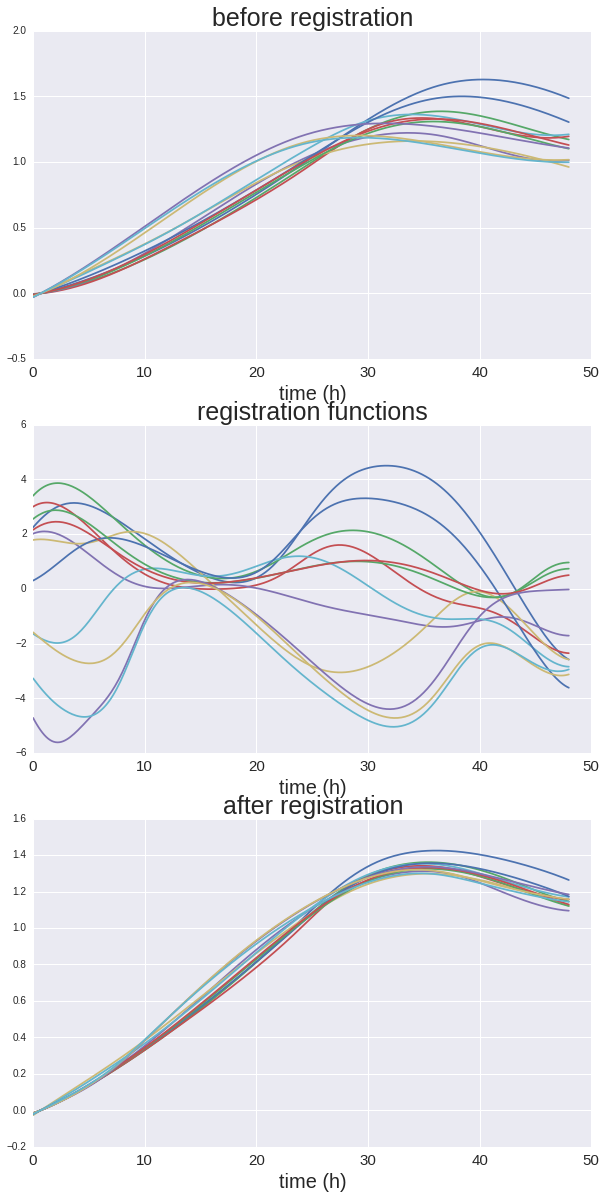

In [302]:
plt.figure(figsize=(10,20))

plotRegistration(sirRstress.data.time,reg,-1)

plt.savefig("figures/ura3_register_growth.png",bbox_inches="tight",dpi=300)

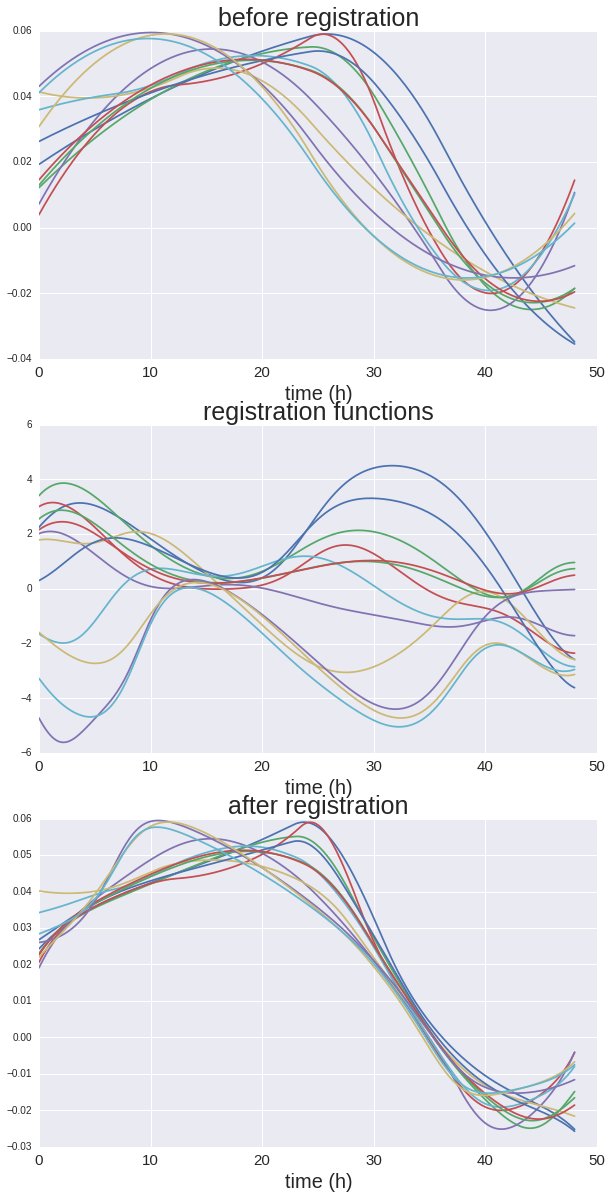

In [303]:
plt.figure(figsize=(10,20))

plotRegistration(sirRstress.data.time,reg,0)

plt.savefig("figures/ura3_register_deriv.png",bbox_inches="tight",dpi=300)

In [345]:
def buildGP(t,splines,skip=1):
    tNew = np.ravel(t.tolist()*len(splines))
    yNew = np.ravel([s(t,deriv=-1) for s in splines])

    tNew = tNew[::skip]
    yNew = yNew[::skip]
    
    gp = GPy.models.GPRegression(tNew[:,None],yNew[:,None])
    gp.optimize()
    return gp

In [346]:
ura3Before = buildGP(sirRnorm.data.time,ura3NormAnalyze[1].xhistory[0],5)

In [355]:
sirRBefore = buildGP(sirRnorm.data.time,sirRNormAnalyze[1].xhistory[0],5)
print sirRBefore


Name                              : GP regression
Log-likelihood                    : 232.363117701
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |       Value       |  Constraint  |  Prior  |  Tied to
  rbf.variance             |    1.66827134375  |     +ve      |         |         
  rbf.lengthscale          |    22.6258002231  |     +ve      |         |         
  Gaussian_noise.variance  |  0.0285311099693  |     +ve      |         |         


In [348]:
ura3After = buildGP(sirRnorm.data.time,ura3NormAnalyze[1].xhistory[-1],5)
print ura3After


Name                              : GP regression
Log-likelihood                    : 678.250395523
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |       Value        |  Constraint  |  Prior  |  Tied to
  rbf.variance             |     1.55722353562  |     +ve      |         |         
  rbf.lengthscale          |     21.7699896003  |     +ve      |         |         
  Gaussian_noise.variance  |  0.00780765026737  |     +ve      |         |         


In [353]:
sirRAfter = buildGP(sirRnorm.data.time,sirRNormAnalyze[1].xhistory[-1],5)
print sirRAfter


Name                              : GP regression
Log-likelihood                    : 756.503929756
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |       Value        |  Constraint  |  Prior  |  Tied to
  rbf.variance             |     1.66043993715  |     +ve      |         |         
  rbf.lengthscale          |     22.3816371357  |     +ve      |         |         
  Gaussian_noise.variance  |  0.00622173470986  |     +ve      |         |         


In [329]:
t = sirRnorm.data.time[::5]

y1 = np.ravel([s(t,deriv=-1) for s in sirRNormAnalyze[1].xhistory[0]])
y2 = np.ravel([s(t,deriv=-1) for s in ura3NormAnalyze[1].xhistory[0]])

t = np.ravel([t]*sirRnorm.key.shape[0])

bayesFactor(t[:,None],y1[:,None],y2[:,None])

62.756840104775961

In [330]:
t = sirRnorm.data.time[::5]

y1 = np.ravel([s(t,deriv=-1) for s in sirRNormAnalyze[1].xhistory[-1]])
y2 = np.ravel([s(t,deriv=-1) for s in ura3NormAnalyze[1].xhistory[-1]])

t = np.ravel([t]*sirRnorm.key.shape[0])

bayesFactor(t[:,None],y1[:,None],y2[:,None])

220.43296747306715

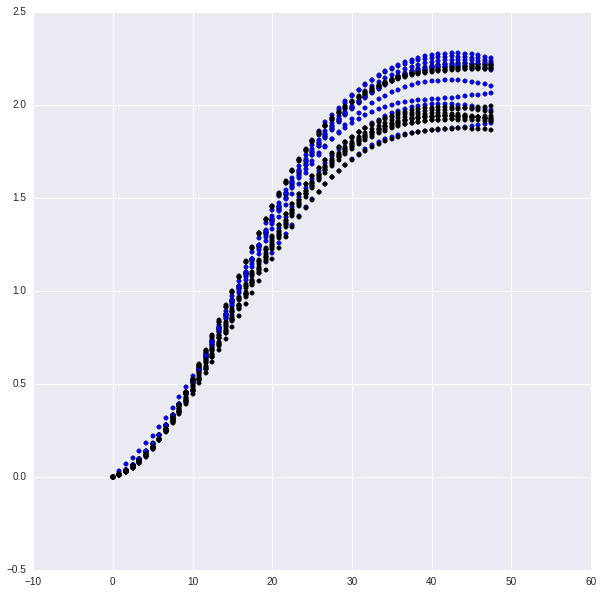

In [335]:
plt.figure(figsize=(10,10))

plt.scatter(t,y1)
plt.scatter(t,y2,c='k')

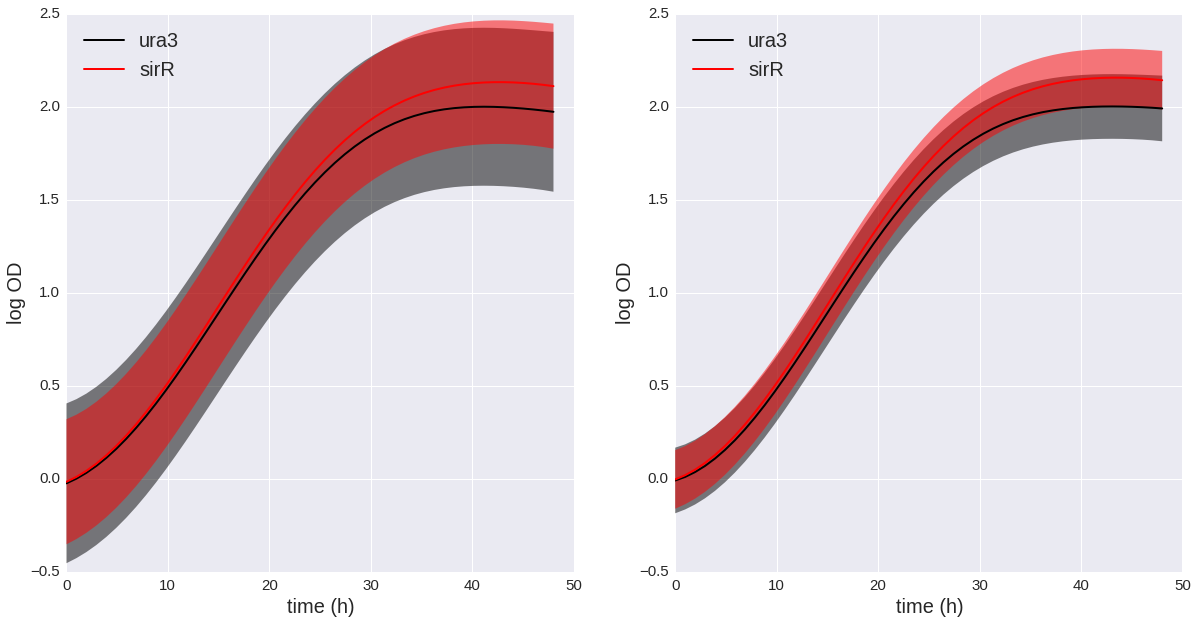

In [362]:
t = np.linspace(0,48)

plt.figure(figsize=(20,10))

plt.subplot(121)

mu,var = ura3Before.predict(t[:,None])
var = np.sqrt(var)
plt.plot(t,mu,'k',linewidth=2,label="ura3")
plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([mu - 1.9600 * var,
                       (mu + 1.9600 * var)[::-1]]),alpha=.5, fc='k', ec='None')

mu,var = sirRBefore.predict(t[:,None])
var = np.sqrt(var)
plt.plot(t,mu,'r',linewidth=2,label="sirR")
plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([mu - 1.9600 * var,
                       (mu + 1.9600 * var)[::-1]]),alpha=.5, fc='r', ec='None')

plt.legend(loc="best",fontsize=20)
plt.xlabel("time (h)",fontsize=20)
plt.ylabel("log OD",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(122)

mu,var = ura3After.predict(t[:,None])
var = np.sqrt(var)
plt.plot(t,mu,'k',linewidth=2,label="ura3")
plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([mu - 1.9600 * var,
                       (mu + 1.9600 * var)[::-1]]),alpha=.5, fc='k', ec='None')

mu,var = sirRAfter.predict(t[:,None])
var = np.sqrt(var)
plt.plot(t,mu,'r',linewidth=2,label="sirR")
plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([mu - 1.9600 * var,
                       (mu + 1.9600 * var)[::-1]]),alpha=.5, fc='r', ec='None')

plt.legend(loc="best",fontsize=20)
plt.xlabel("time (h)",fontsize=20)
plt.ylabel("log OD",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig("figures/sirR_vs_ura3_register_GP.png",bbox_inches="tight",dpi=300)